# Packages

In [1]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

import seaborn as sns
import pandas_datareader.data as web
import requests
import json

import country_converter as coco
cc = coco.CountryConverter()

!wget http://i.imgur.com/2e3FQaz.png
!mv 2e3FQaz.png ../figs/Cecon_Logo.png

import matplotlib.image as image

logo = "../figs/Cecon_Logo.png"
logo = image.imread(logo)

/home/gpetrini/.local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


--2020-05-29 10:07:14--  http://i.imgur.com/2e3FQaz.png
Resolvendo i.imgur.com (i.imgur.com)... 199.232.32.193
Conectando-se a i.imgur.com (i.imgur.com)|199.232.32.193|:80... conectado.
A requisição HTTP foi enviada, aguardando resposta... 301 Moved Permanently
Localização: https://i.imgur.com/2e3FQaz.png [redirecionando]
--2020-05-29 10:07:14--  https://i.imgur.com/2e3FQaz.png
Conectando-se a i.imgur.com (i.imgur.com)|199.232.32.193|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 126925 (124K) [image/png]
Salvando em: “2e3FQaz.png”

2e3FQaz.png         100%[===================>] 123,95K   211KB/s    em 0,6s    

2020-05-29 10:07:16 (211 KB/s) - “2e3FQaz.png” salvo [126925/126925]



# Data

In [2]:
infos = {
    'Country' : [],
    'Type': [],
    'Usage': [],
    'Source': [],
    'Units' : [],
    'Frequency' : [],
    'Link' : []
        }

In [3]:
def get_energy_links(start=1577833200000, end=1590443159999,  path='../data/'):
    countries = [
        "AT", # Austria
        'DE', # Germany
    ]
    for country in countries:
        url = f"https://www.smard.de/en/downloadcenter/download_market_data/5730#!?downloadAttributes=%7B%22selectedCategory%22:1,%22selectedSubCategory%22:1,%22selectedRegion%22:%22{country}%22,%22from%22:{start},%22to%22:{end},%22selectedFileType%22:%22CSV%22%7D"
        url = url.replace('%22', '"').replace('%7B', '{').replace('%7D', '}')
        print(url)

In [11]:
def ploter(df, country, days=365, units="MWh"):
    fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=300)
    df.plot(ax=ax[0], 
             ls='-', 
             title= f"Energy consumption for {country}\nTotal {units}",
             color='darkred'
            )
    df.pct_change(days).dropna().plot(ax=ax[1], 
             ls='-', 
             title= f"Energy consumption for {country}",
             color='darkred',
             label="Year over Year Growth rate"
            )
    df.pct_change(days).rolling(7).mean().dropna().plot(ax=ax[1], 
             ls='--', 
             label="1 Week Moving average",
             color='black'
            )
    ax[1].legend(labels=("YoY Growth rate", "1 Week Moving average"))
    ax[1].axhline(y=0, ls='--', color='black')
    
    ax2 = plt.axes([0.08,0.12,0.2,0.2])
    ax2.imshow(logo, aspect='auto', zorder=0, alpha=.5)
    ax2.axis('off')
    ax3 = plt.axes([0.58,0.12,0.2,0.2])
    ax3.imshow(logo, aspect='auto', zorder=0, alpha=.5)
    ax3.axis('off')
    sns.despine()
    plt.tight_layout()
    plt.show()
    fig.savefig(
        f"../figs/Energy/DailyEnergyConsumption_{country}_{units}.svg", 
        dpi = 300, 
        bbox_inches='tight',pad_inches=0
    )
    return fig, ax

## Austria: AUS

<ipython-input-4-4fa9ab8fbc1c>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


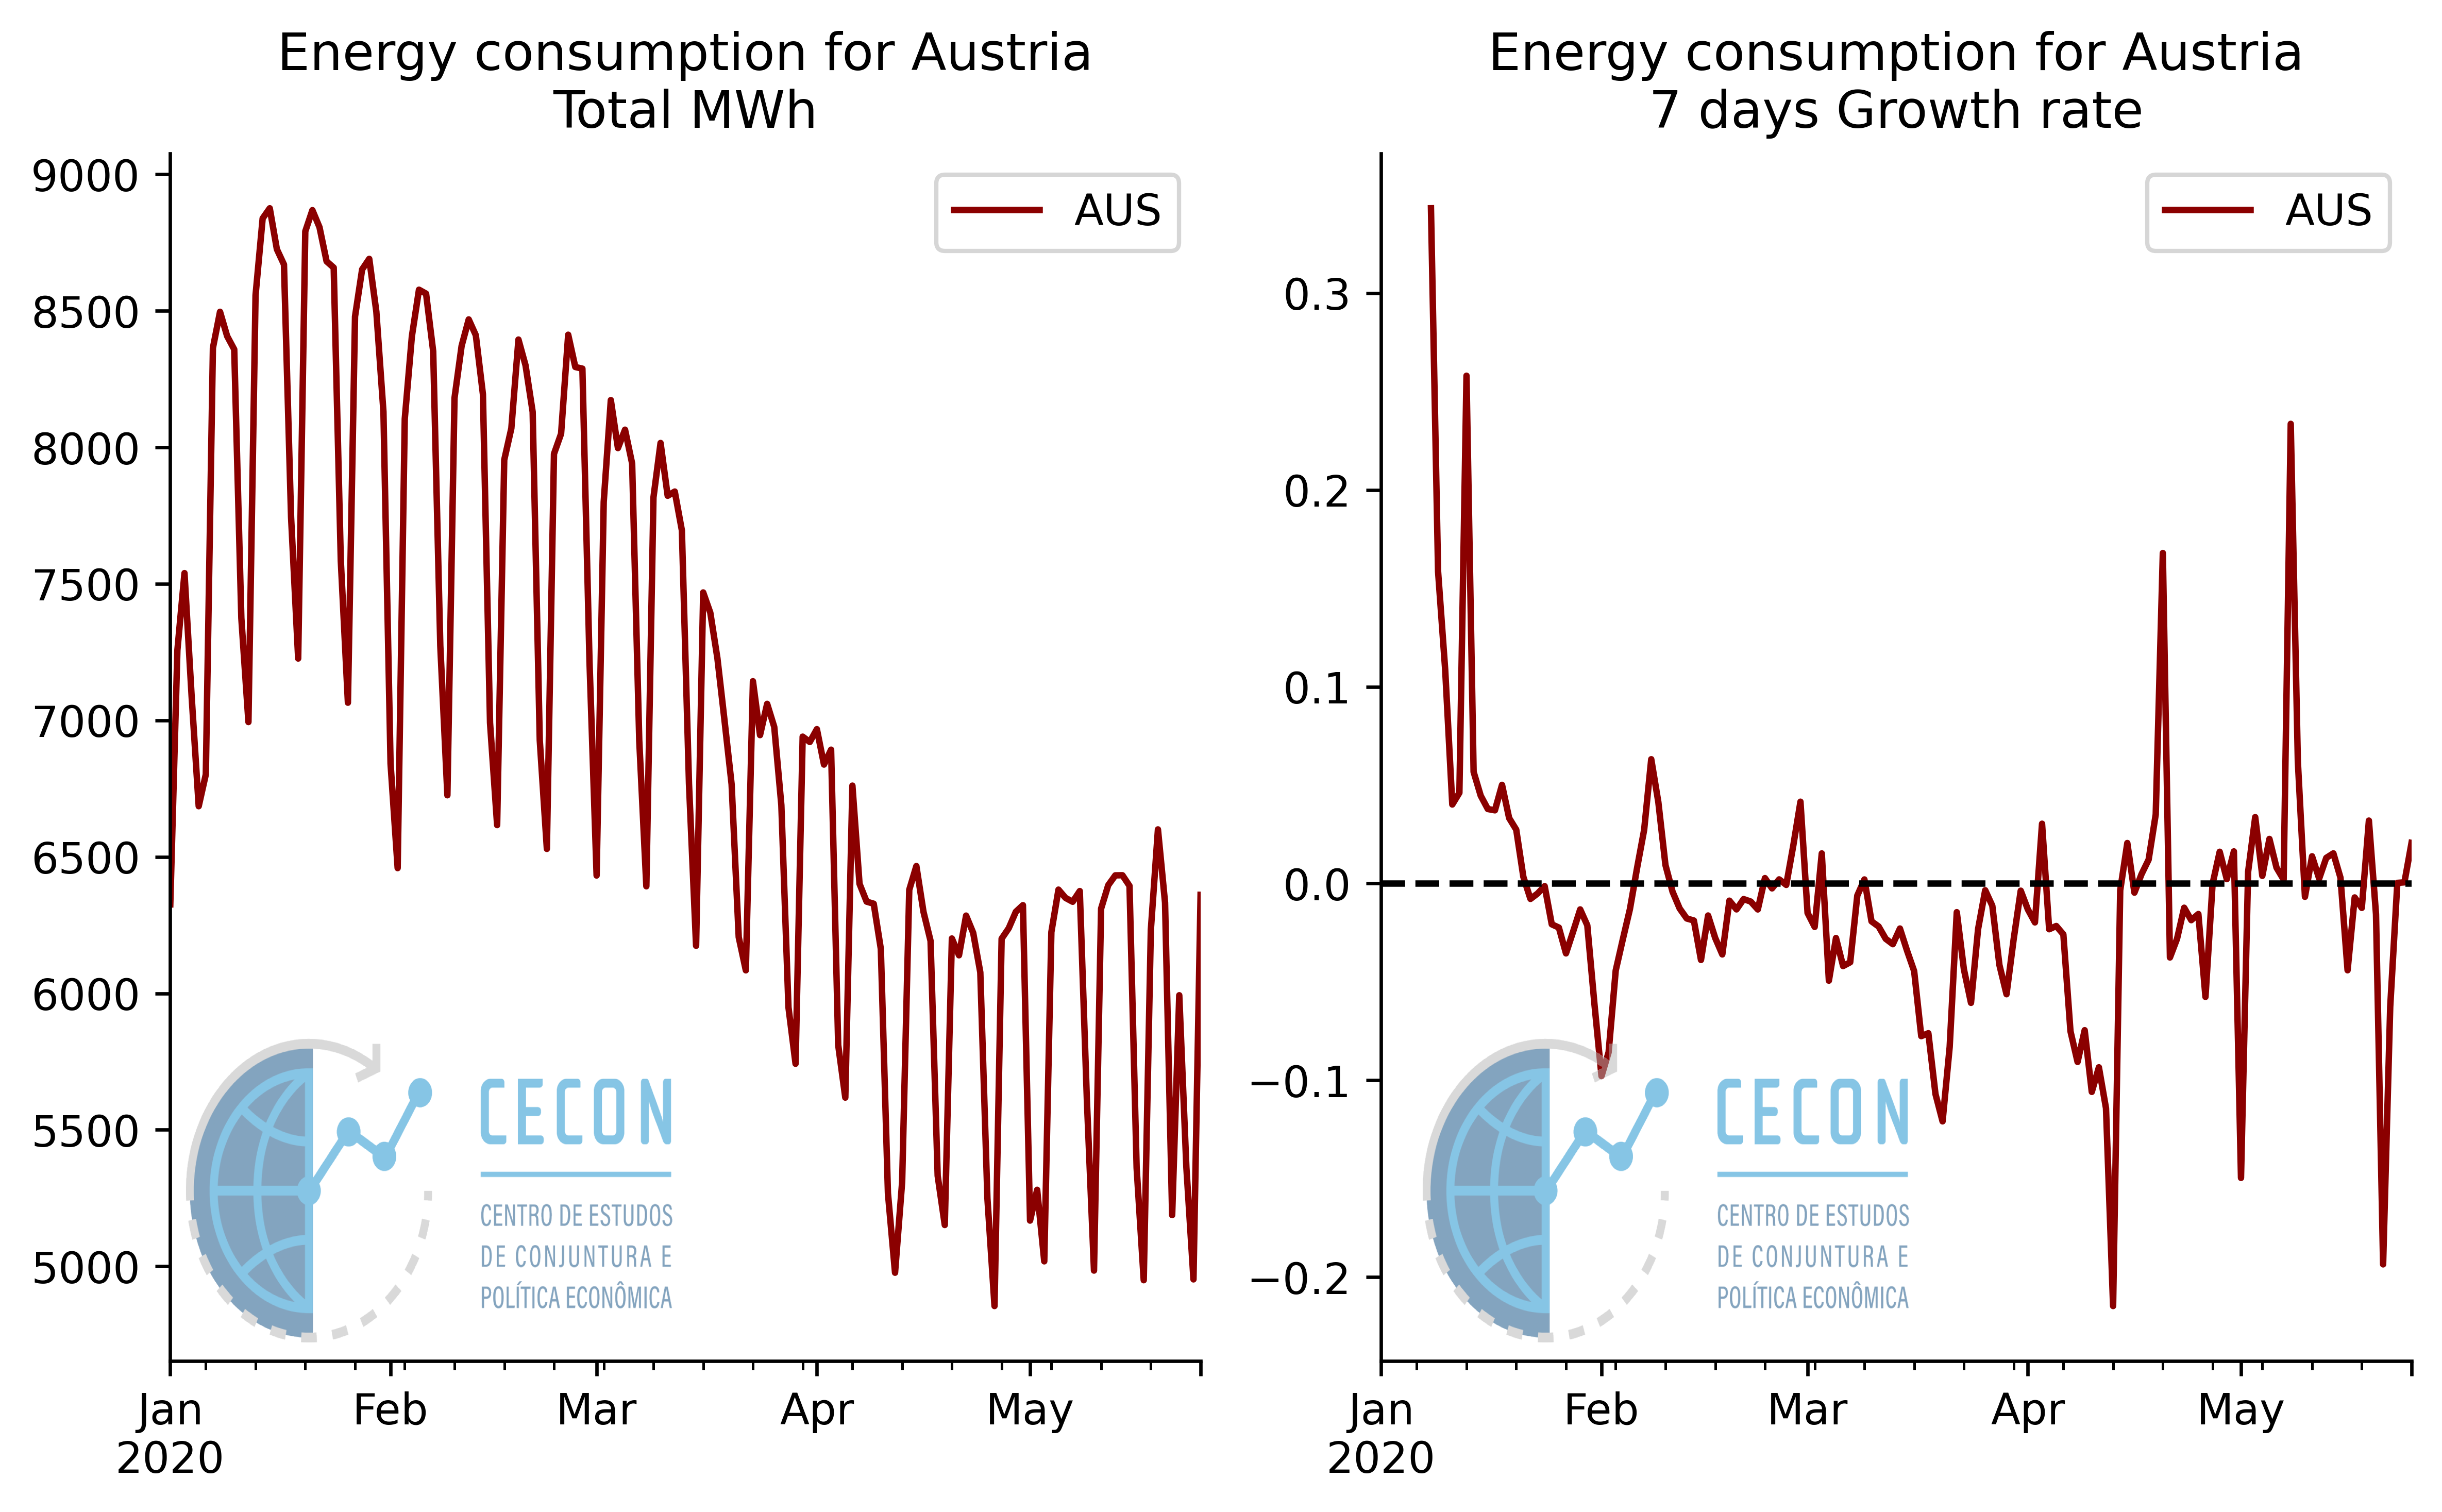

AUS
                       
2020-01-01  6325.791667
2020-01-02  7256.833333
2020-01-03  7539.166667
2020-01-04  7089.750000
2020-01-05  6685.333333
...                 ...
2020-05-21  5187.541667
2020-05-22  5992.916667
2020-05-23  5362.583333
2020-05-24  4952.166667
2020-05-25  6360.727273

[146 rows x 1 columns]

In [5]:
aus = pd.read_csv(
    '../data/Energy/AUS.csv', 
    sep=';', 
    index_col=["Date", "Time of day"], 
    parse_dates=True, 
    thousands=',', decimal='.'
)
sources = ['Biomass[MWh]', 'Hydropower[MWh]', 
                       'Wind onshore[MWh]', 'Photovoltaics[MWh]',
                       'Other renewable[MWh]', 'Fossil hard coal[MWh]',
                       'Fossil gas[MWh]', 'Hydro pumped storage[MWh]',
                       'Other conventional[MWh]'
                      ]

#aus[sources] = aus[sources].apply(pd.to_numeric, errors='coerce') 
aus["Total[MWh]"] = aus["Total[MWh]"].str.replace(',', '')
aus["Total[MWh]"] = pd.to_numeric(aus["Total[MWh]"], errors='coerce')
aus["Total[MWh]"] = aus["Total[MWh]"]*(4) # TODO Check later: MWh -> MW
#aus["Total[MWh]"] = aus["Total[MWh]"].rolling(4).mean() # TODO Check later: MWhmed
aus = aus.groupby(by='Date', sort=False).mean()
aus = aus[["Total[MWh]"]]
aus.index.name = ''
aus.columns = ["AUS"]
df_ = aus.copy()

infos['Country'].append("AUS")
infos["Type"].append('Consumption')
infos['Usage'].append(np.nan)
infos['Source'].append("All")
infos['Units'].append("Total[MWh]")
infos['Frequency'].append('Quarterhour')
infos['Link'].append(np.NaN)

ploter(
    df=aus, 
    country="Austria", 
    days = 7,
    units="MWh"
)

aus

## Germany: GER

<ipython-input-4-4fa9ab8fbc1c>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


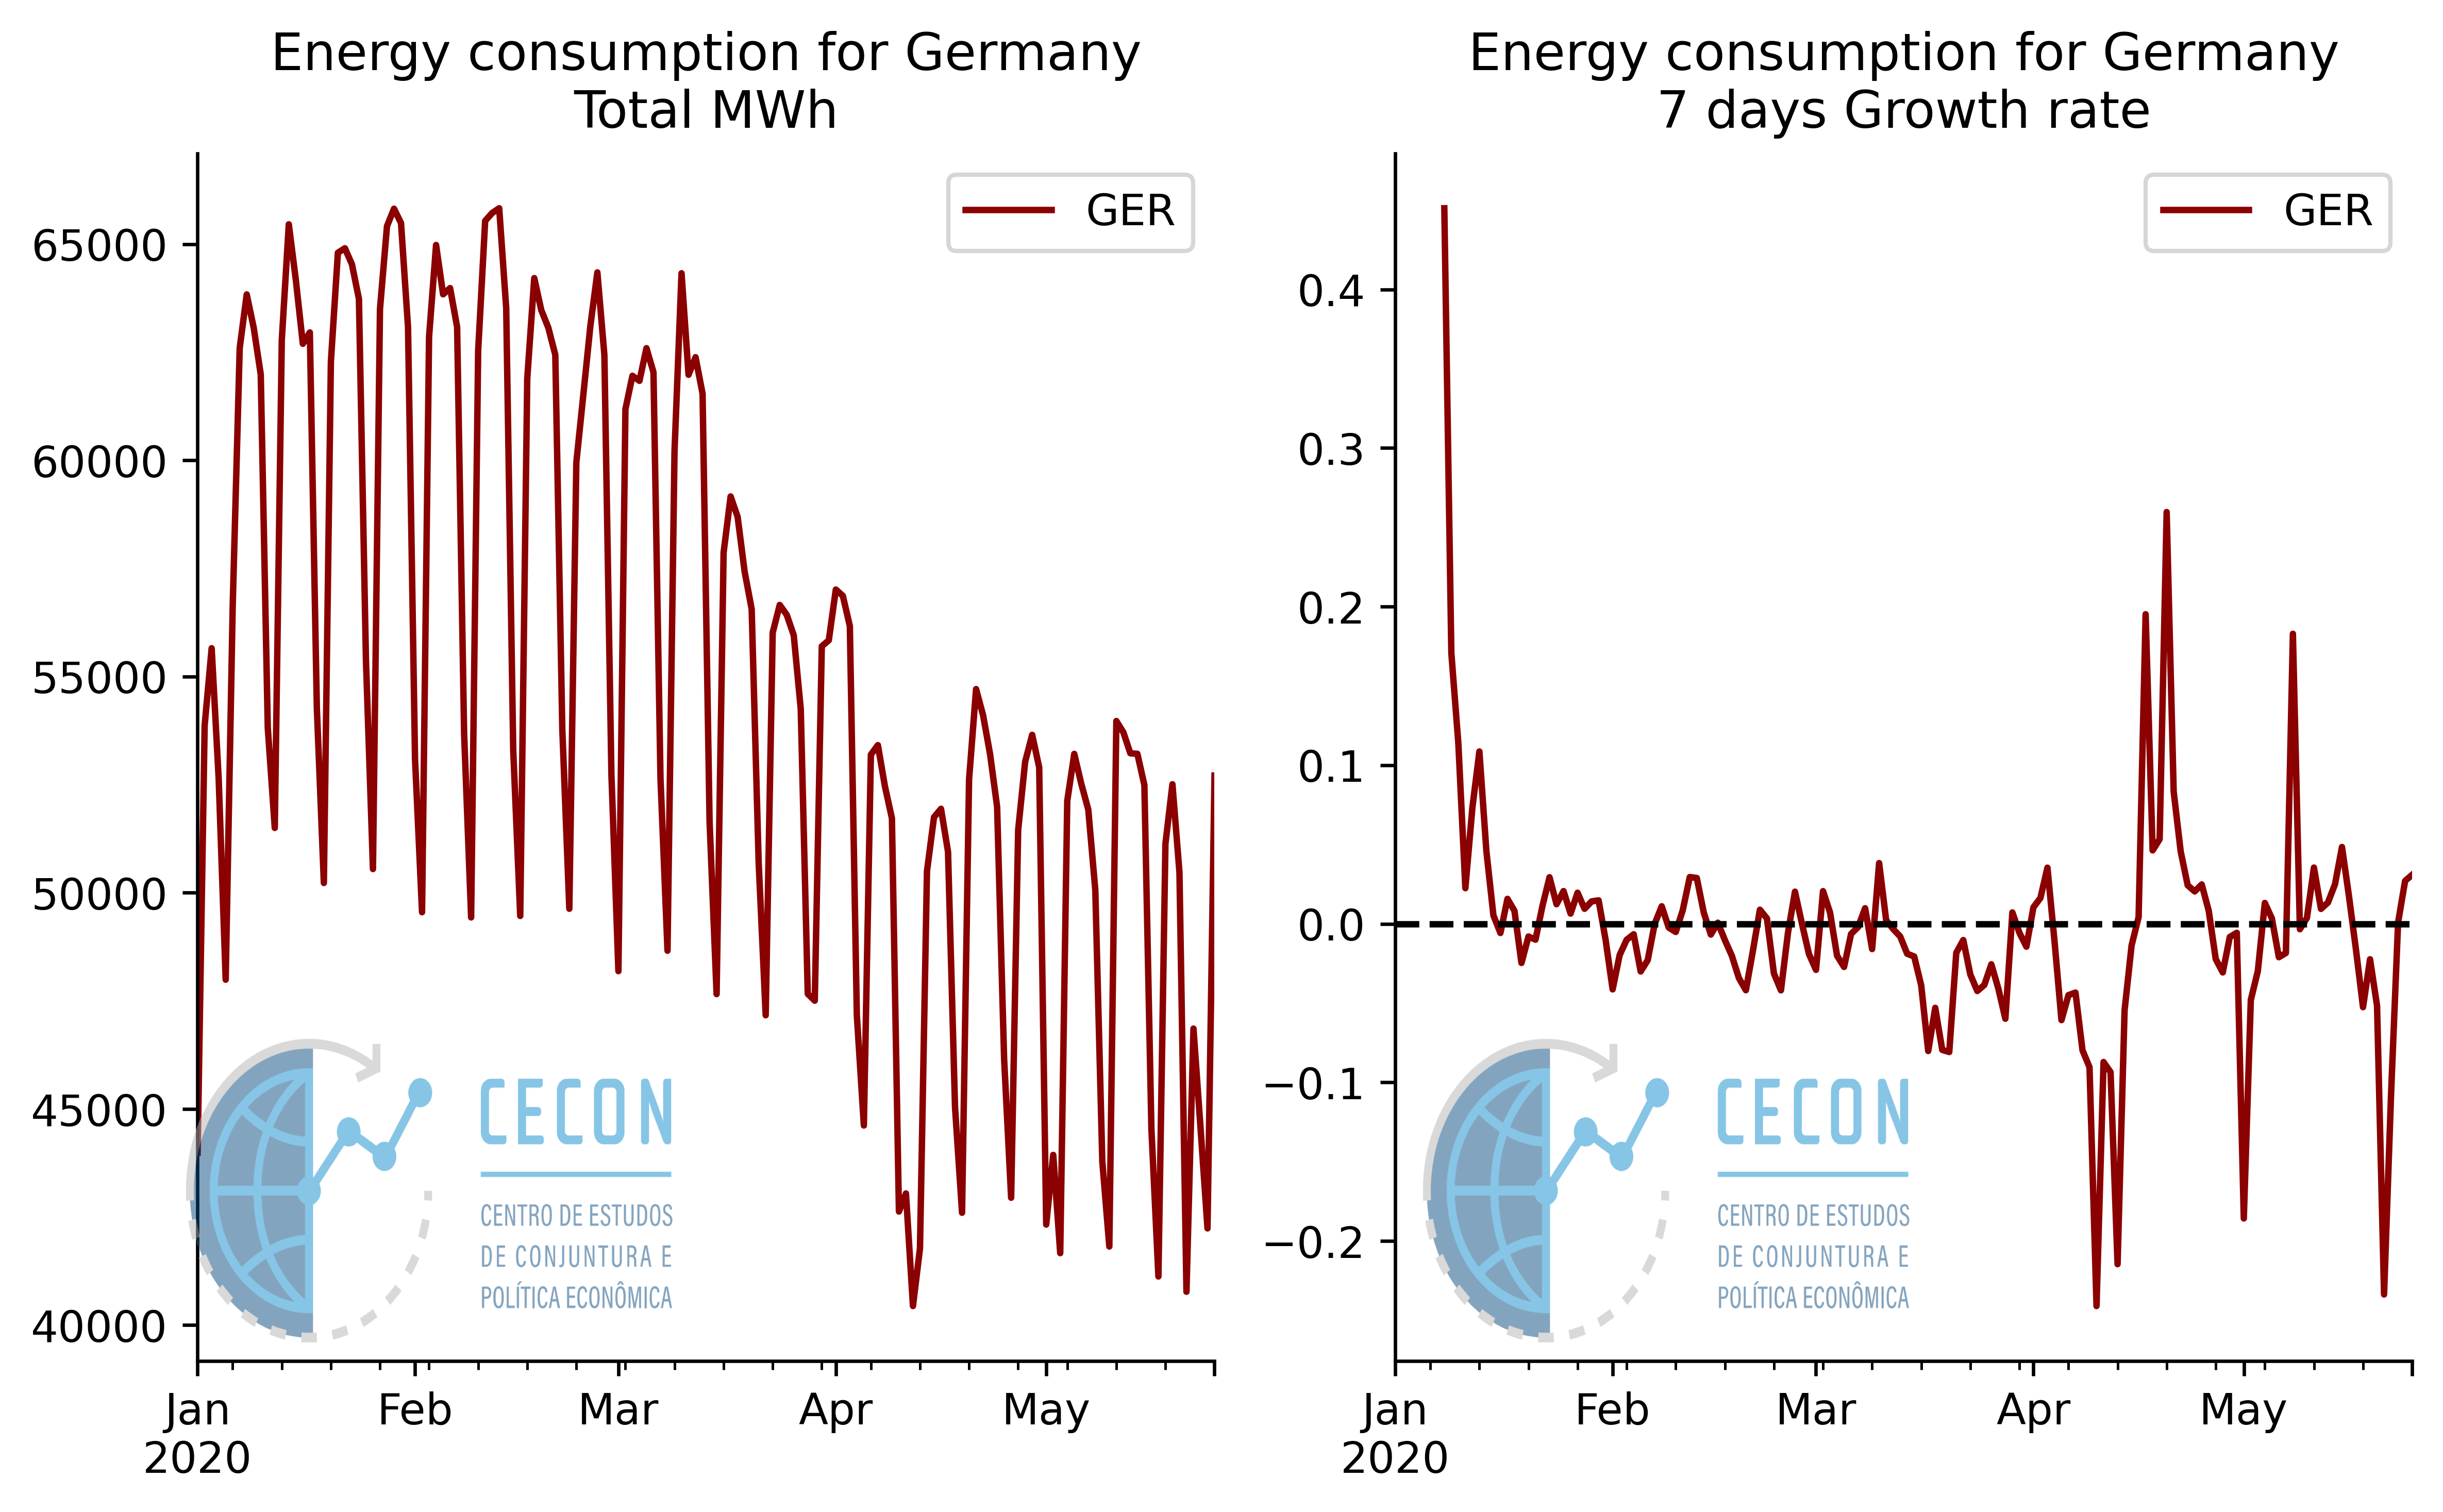

GER
                        
2020-01-01  43989.000000
2020-01-02  53865.750000
2020-01-03  55655.250000
2020-01-04  52640.625000
2020-01-05  47989.625000
...                  ...
2020-05-21  40772.541667
2020-05-22  46859.041667
2020-05-23  44575.916667
2020-05-24  42237.958333
2020-05-25  52710.831461

[146 rows x 1 columns]

In [6]:
ger = pd.read_csv(
    '../data/Energy/GER.csv', 
    sep=';', 
    index_col=["Date", "Time of day"], 
    parse_dates=True, 
    thousands=',', decimal='.', 
)
sources = ['Biomass[MWh]', 'Hydropower[MWh]', 
                       'Wind onshore[MWh]', 'Photovoltaics[MWh]',
                       'Other renewable[MWh]', 'Fossil hard coal[MWh]',
                       'Fossil gas[MWh]', 'Hydro pumped storage[MWh]',
                       'Other conventional[MWh]'
                      ]

#ger[sources] = ger[sources].apply(pd.to_numeric, errors='coerce') 
ger["Total[MWh]"] = ger["Total[MWh]"].str.replace(',', '')
ger["Total[MWh]"] = pd.to_numeric(ger["Total[MWh]"], errors='coerce')
ger["Total[MWh]"] = ger["Total[MWh]"]*(4) # TODO Check later: MWh -> MW
#ger["Total[MWh]"] = ger["Total[MWh]"].rolling(4).mean() # TODO Check later: MWhmed
ger = ger.groupby(by='Date', sort=False).mean()
ger = ger[["Total[MWh]"]]
ger.index.name = ''
ger.columns = ["GER"]

ploter(
    df=ger, 
    country="Germany", 
    days = 7,
    units="MWh"
)

infos['Country'].append("GER")
infos["Type"].append('Consumption')
infos['Usage'].append(np.nan)
infos['Source'].append("All")
infos['Units'].append("Total[MWh]")
infos['Frequency'].append('Quarterhour')
infos['Link'].append(np.NaN)

ger

## Luxembourg: LUX

<ipython-input-4-4fa9ab8fbc1c>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


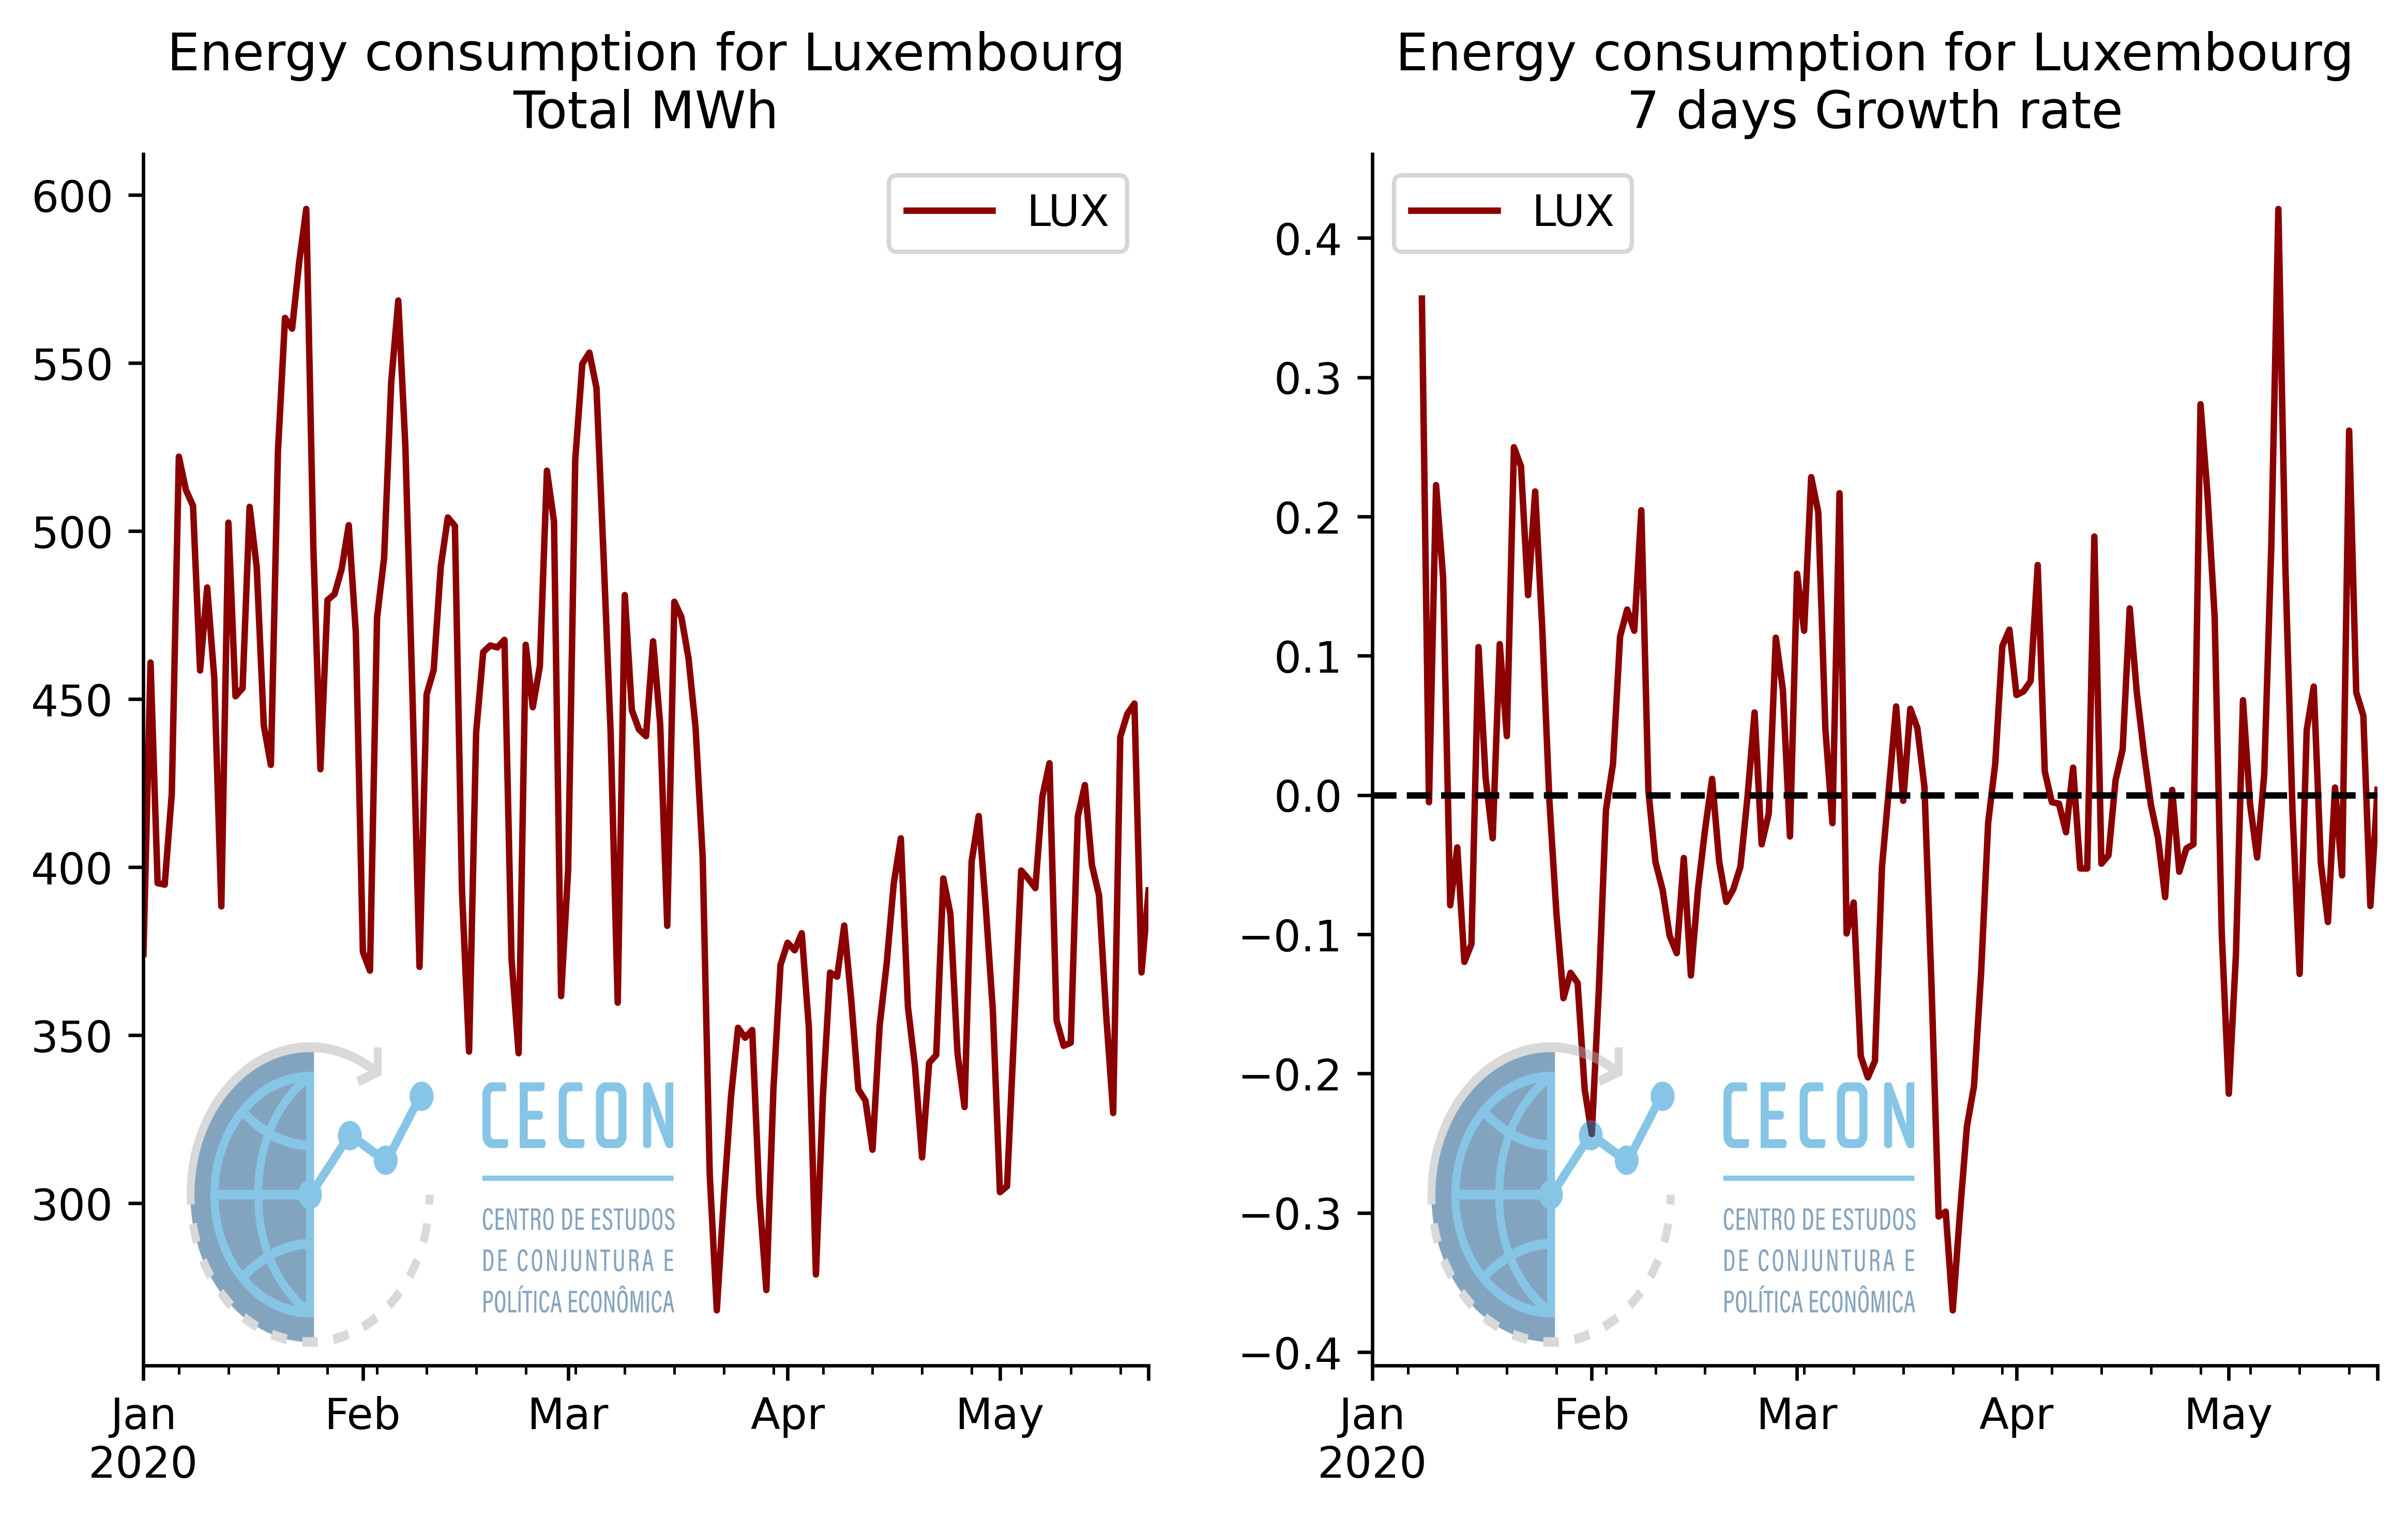

LUX
                      
2020-01-01  374.166667
2020-01-02  460.875000
2020-01-03  395.250000
2020-01-04  394.791667
2020-01-05  421.708333
...                ...
2020-05-18  438.750000
2020-05-19  445.625000
2020-05-20  448.666667
2020-05-21  368.666667
2020-05-22  393.086957

[143 rows x 1 columns]

In [7]:
lux = pd.read_csv(
    '../data/Energy/LUX.csv', 
    sep=';', 
    index_col=["Date", "Time of day"],  
    thousands=',', decimal='.',
    parse_dates=True
)
lux["Total[MWh]"] = lux["Total[MWh]"].str.replace(',', '')
lux["Total[MWh]"] = pd.to_numeric(lux["Total[MWh]"], errors='coerce')
lux["Total[MWh]"] = lux["Total[MWh]"]*(4) # TODO Check later: MWh -> MW
#lux["Total[MWh]"] = lux["Total[MWh]"].rolling(4).mean() # TODO Check later: MWhmed
lux = lux.groupby(by='Date', sort=False).mean()
lux.index.name = ''
lux.columns = ["LUX"]

ploter(
    df=lux, 
    country="Luxembourg", 
    days = 7,
    units="MWh"
)

infos['Country'].append("LUX")
infos["Type"].append('Consumption') # Production not available
infos['Usage'].append(np.nan)
infos['Source'].append(np.nan)
infos['Units'].append("MWh")
infos['Frequency'].append('Quarterhour')
infos['Link'].append(np.NaN)

lux

## Brazil: BRA

## Share

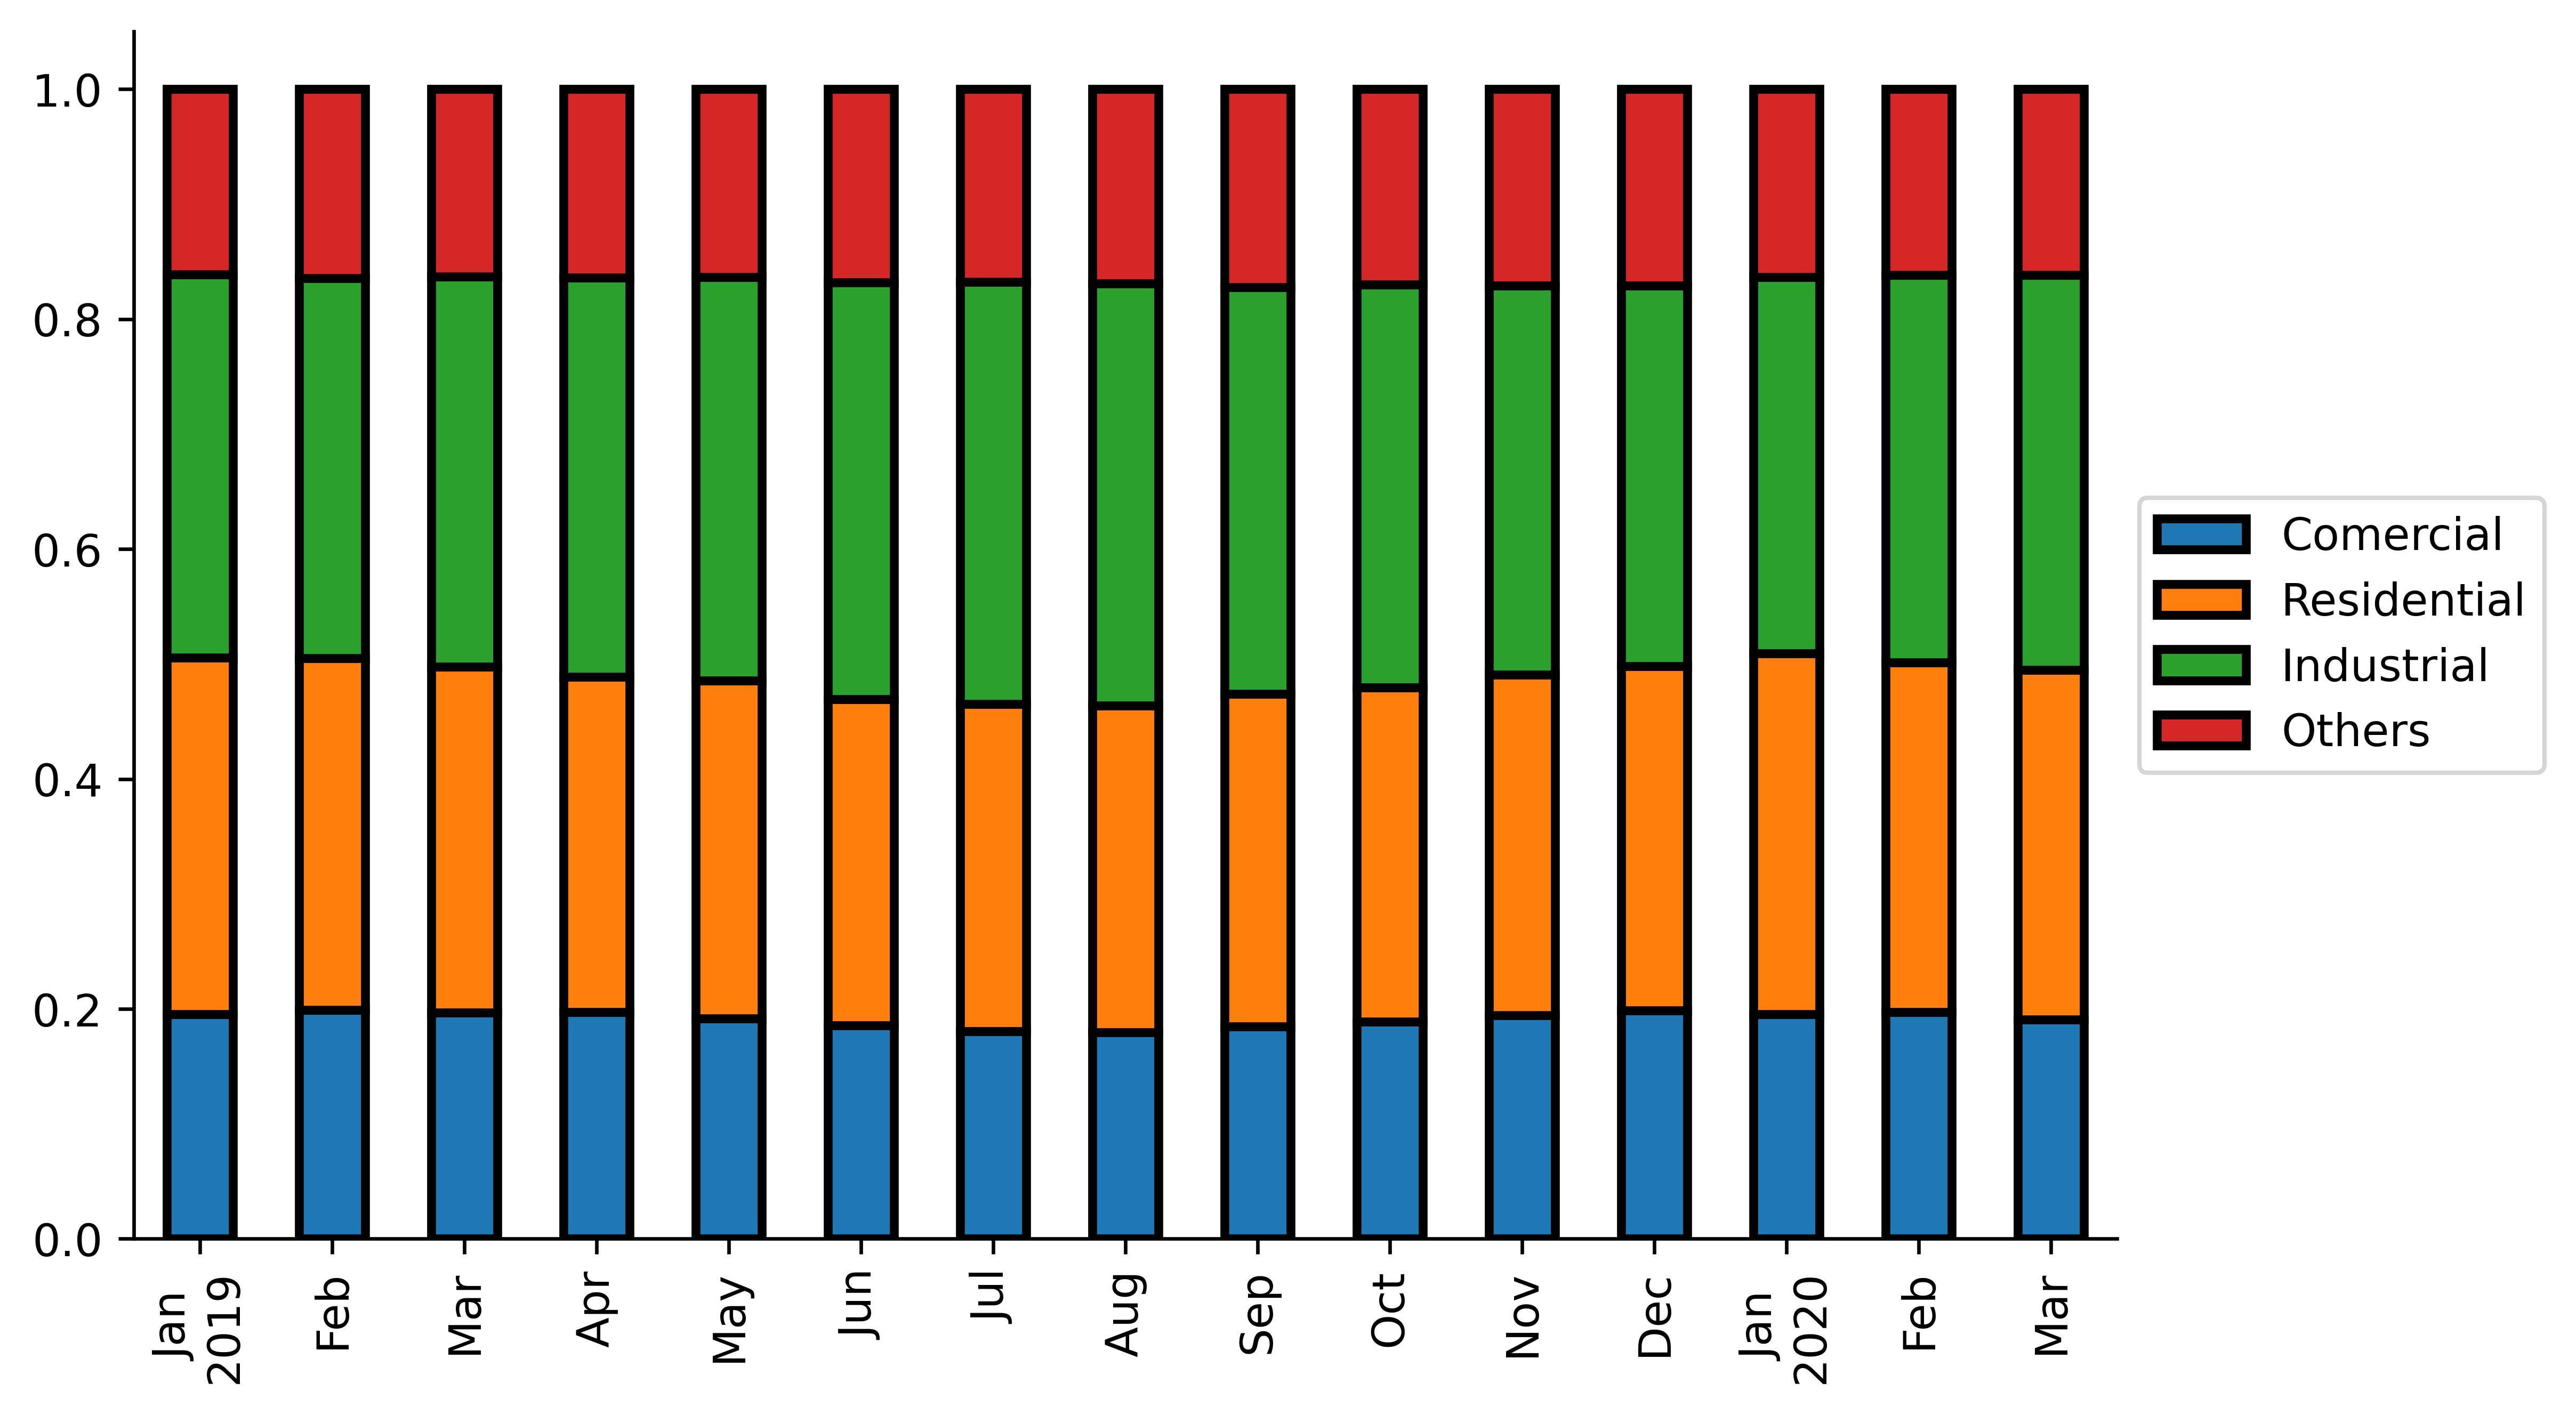

Comercial Residential Industrial    Others Non-Residential
1979-01-31  0.130615    0.215427   0.530389  0.123569        0.784573
1979-02-28   0.13106    0.209569   0.537091   0.12228        0.790431
1979-03-31  0.130365     0.21411   0.533917  0.121608         0.78589
1979-04-30  0.128287    0.206562   0.541288  0.123863        0.793438
1979-05-31  0.124237    0.210293    0.54614   0.11933        0.789707
...              ...         ...        ...       ...             ...
2019-11-30  0.194333    0.296307   0.338519  0.170841        0.703693
2019-12-31  0.198463    0.299626   0.330781   0.17113        0.700374
2020-01-31   0.19546    0.313703    0.32753  0.163307        0.686297
2020-02-29  0.197082    0.304017   0.337351  0.161549        0.695983
2020-03-31  0.190902    0.303961   0.343634  0.161503        0.696039

[495 rows x 5 columns]

In [72]:
share = pd.read_excel(
    '../data/Consumo de Energia Eletrica/Consumo_Energia_EPE.xlsx',
    sheet_name='BR', 
    parse_dates=True,
    skiprows=11,
    usecols="A:F",
#     usecols=[
#         "Período", 
#         "TOTAL",
#         "Comercial",
#         "Residencial",
#         "Indústrial",
#         "Outros"
#     ], 
    index_col=[0],
)
share = share[:-11] # Until March: Change here
share.index.name=''
share.index = pd.date_range(
    start = share.index[0],
    periods=share.shape[0],
    #end = share.index[-1],
    freq='M', 
)
share = share.apply(lambda x: x/share["TOTAL"]).drop(["TOTAL"], axis='columns')
share.columns = [
    "Comercial",
    "Residential",
    "Industrial",
    "Others"
]

fig, ax = plt.subplots(figsize=(8,5), dpi=300)

share["2019":].plot(
    ax=ax,
    kind='bar',
    stacked=True,
    edgecolor='black',
    lw=2
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month
ax.set_xticklabels(map(lambda x: line_format(x), share["2019":].index))


sns.despine()
plt.show()
share["Non-Residential"] = 1- share["Residential"]
share

## Daily comsumption

In [73]:
datelist = pd.date_range(
    start = "01/31/2018",
    end = str(dt.today().strftime("%m/%d/%Y")),
    freq='M',
).to_pydatetime().tolist()
datelist = [date.strftime("%Y_%m_%d") for date in datelist] #+ [str(dt.today().strftime("%Y_%m_%d"))]

bra = pd.DataFrame()

for date in datelist:
    url = f"http://sdro.ons.org.br/SDRO/DIARIO/{date}/HTML/07_DadosDiariosAcumulados_Regiao.html"
    bra = bra.append(pd.read_html(
        url,
        parse_dates=True,
        index_col = [0], skiprows=1, header=0, 
        thousands='.', #decimal=','
            )[0])
bra = bra[["Total"]] # TODO Check later: MWmed dia -> MW
bra.columns = ["BRA"]
bra.index = pd.date_range(
    start = bra.index[0],
    end = bra.index[-1],
    freq='D', 
)
bra

BRA
2018-01-01  52626
2018-01-02  63268
2018-01-03  66312
2018-01-04  66167
2018-01-05  66297
...           ...
2020-04-26  50825
2020-04-27  57644
2020-04-28  58886
2020-04-29  59618
2020-04-30  59465

[851 rows x 1 columns]

In [107]:
energy_bra = bra.merge(share["2018":], left_index=True, right_index=True, how='left', ).fillna(method='ffill', ).fillna(method='bfill')
energy_bra["Daily Industrial"] = energy_bra["BRA"]*energy_bra["Industrial"]
energy_bra["Daily Non-Residential"] = energy_bra["BRA"]*energy_bra["Non-Residential"]
energy_bra["Daily Residential"] = energy_bra["BRA"]*energy_bra["Residential"]
energy_bra

BRA  Comercial  Residential  Industrial    Others  \
2018-01-01  52626   0.190269     0.298904    0.346248  0.164579   
2018-01-02  63268   0.190269     0.298904    0.346248  0.164579   
2018-01-03  66312   0.190269     0.298904    0.346248  0.164579   
2018-01-04  66167   0.190269     0.298904    0.346248  0.164579   
2018-01-05  66297   0.190269     0.298904    0.346248  0.164579   
...           ...        ...          ...         ...       ...   
2020-04-26  50825   0.190902     0.303961    0.343634  0.161503   
2020-04-27  57644   0.190902     0.303961    0.343634  0.161503   
2020-04-28  58886   0.190902     0.303961    0.343634  0.161503   
2020-04-29  59618   0.190902     0.303961    0.343634  0.161503   
2020-04-30  59465   0.190902     0.303961    0.343634  0.161503   

            Non-Residential  Daily Industrial  Daily Non-Residential  \
2018-01-01         0.701096      18221.647075           36895.881980   
2018-01-02         0.701096      21906.418256           44356.946397   
2018-01-03         0.701096      22960.397158           46491.082846   
2018-01-04         0.701096      22910.191199           46389.423915   
2018-01-05         0.701096      22955.203438           46480.566405   
...                     ...               ...                    ...   
2020-04-26         0.696039      17465.183762           35376.171984   
2020-04-27         0.696039      19808.422091           40122.460558   
2020-04-28         0.696039      20235.215170           40986.940747   
2020-04-29         0.696039      20486.755052           41496.441148   
2020-04-30         0.696039      20434.179093           41389.947212   

            Daily Residential  
2018-01-01       15730.118020  
2018-01-02       18911.053603  
2018-01-03       19820.917154  
2018-01-04       19777.576085  
2018-01-05       19816.433595  
...                       ...  
2020-04-26       15448.828016  
2020-04-27       17521.539442  
2020-04-28       17899.059253  
2020-04-29       18121.558852  
2020-04-30       18075.052788  

[851 rows x 9 columns]

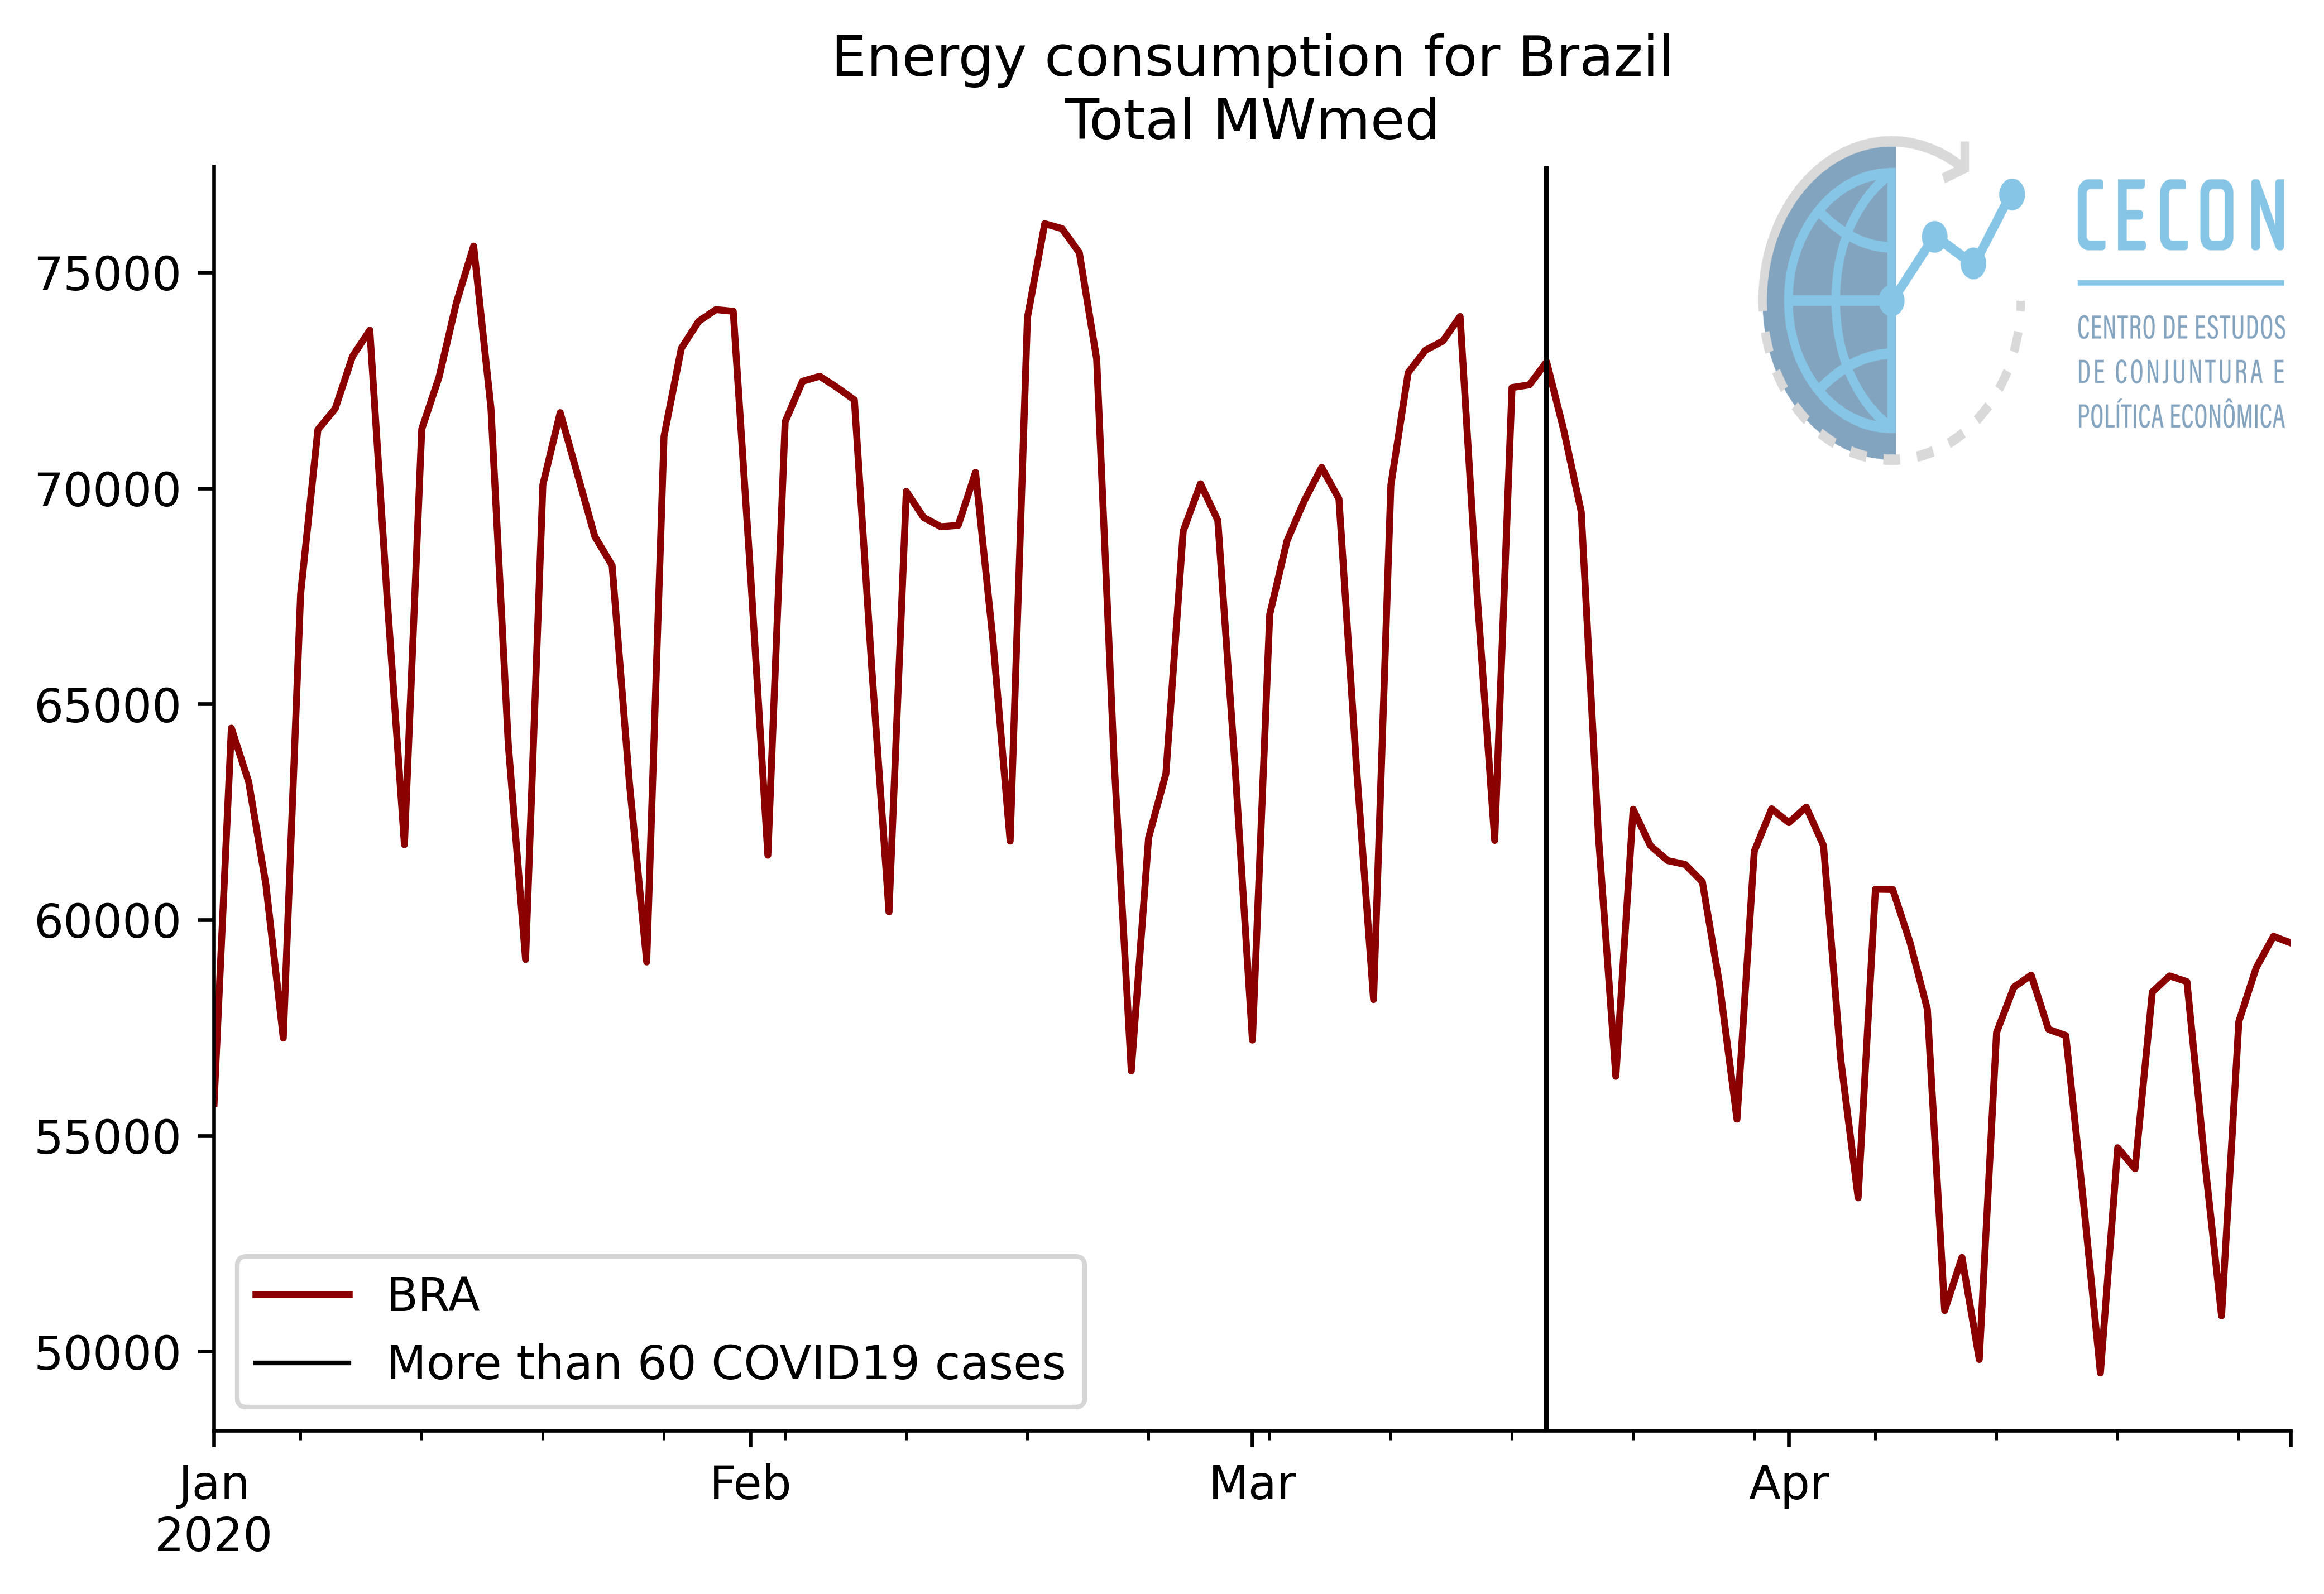

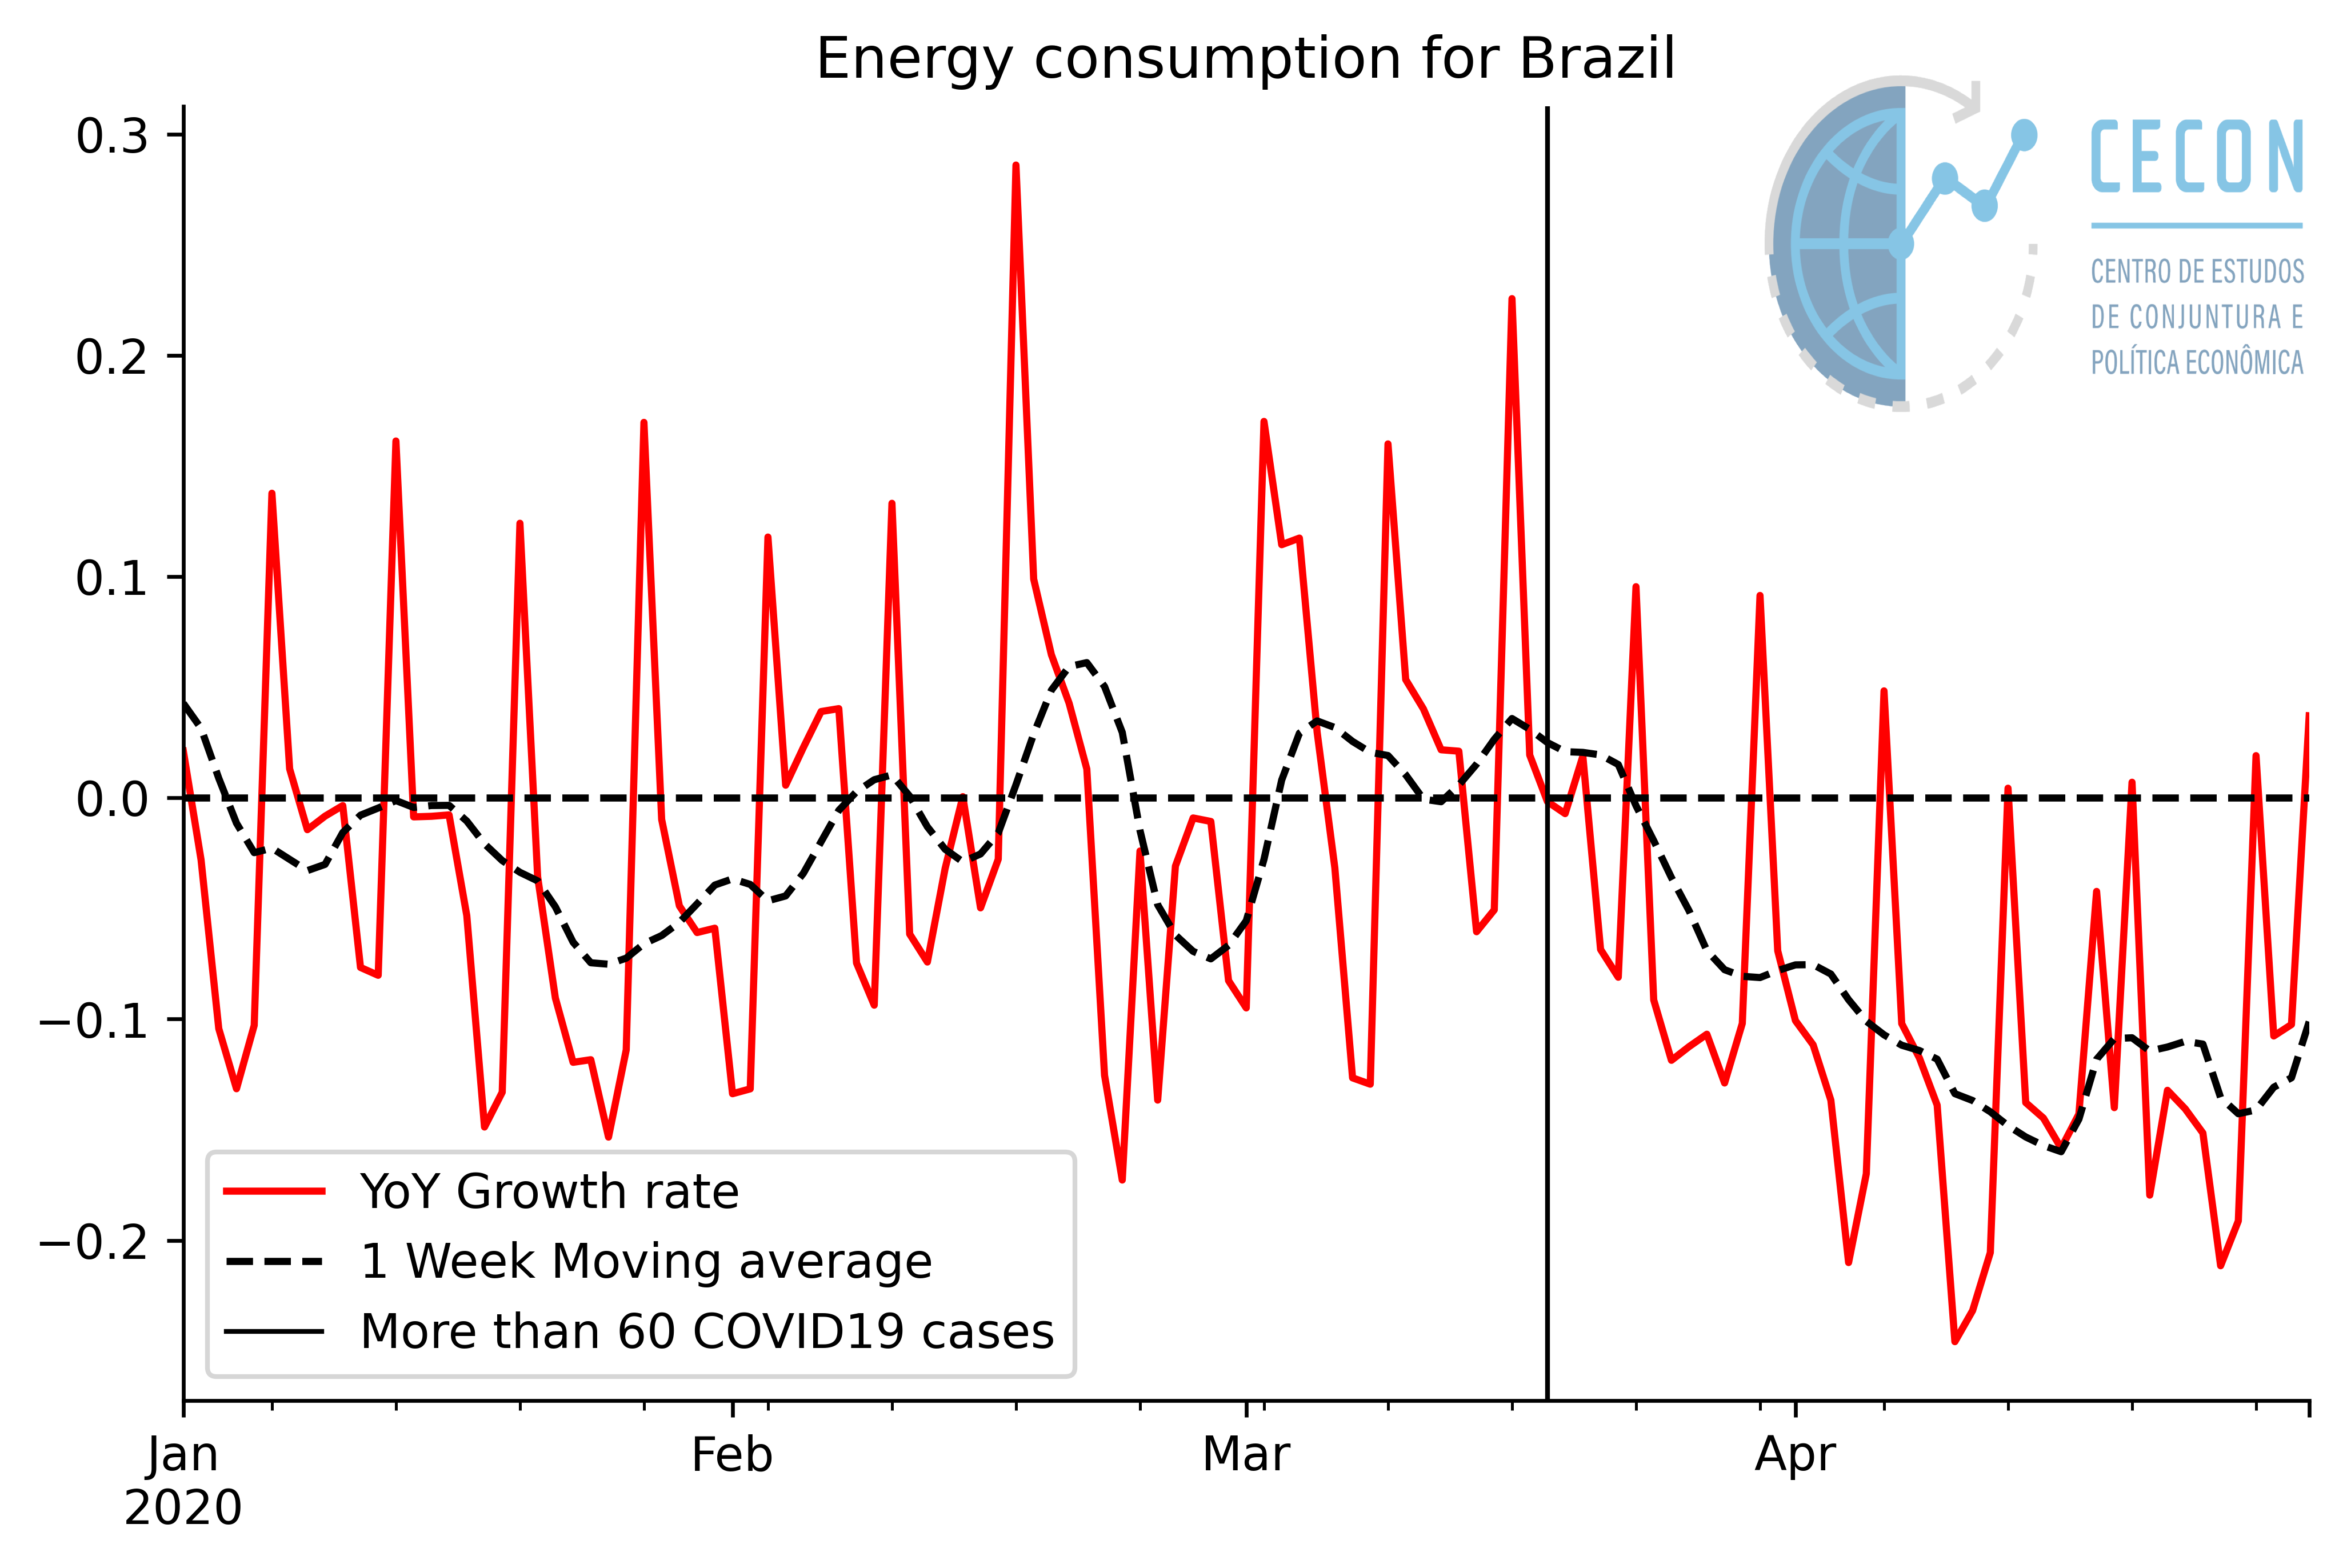

NameError: name 'infos' is not defined

In [108]:
country="Brazil"
units="MWmed"
days=365
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
bra["2020":].plot(ax=ax, 
         ls='-', 
         title= f"Energy consumption for {country}\nTotal {units}",
         color='darkred'
        )
ax.axvline(x = '2020-03-18', color='black', ls='-', lw=1, label='More than 60 COVID19 cases')
ax.legend()
ax2 = plt.axes([0.7,0.7,0.2,0.2])
ax2.imshow(logo, aspect='auto', zorder=0, alpha=.5)
ax2.axis('off')
sns.despine()
plt.show()
fig.savefig(
    f"../figs/Energia/DailyEnergyConsumption_{country}_{units}_level.svg", 
    dpi = 300, 
    bbox_inches='tight',pad_inches=0
)


fig, ax = plt.subplots(figsize=(8,5), dpi=300)
bra.pct_change(days)["2020":].plot(ax=ax, 
         ls='-', 
         title= f"Energy consumption for {country}",
         color='red',
         label="Year over Year Growth rate",
         zorder=-1
        )
bra.pct_change(days).rolling(7).mean()["2020":].plot(ax=ax, 
         ls='--', 
         label="1 Week Moving average",
         color='black'
        )
ax.axvline(x = '2020-03-18', color='black', ls='-', lw=1.5, label='More than 60 COVID19 cases')
ax.axvline(x = '2020-03-24', color='gray', ls='-', lw=1.5, label='Beginning of social isolation in SP')
ax.legend(labels=("YoY Growth rate", "1 Week Moving average", 'More than 60 COVID19 cases'))
ax.axhline(y=0, ls='--', color='black')

ax2 = plt.axes([0.7,0.7,0.2,0.2])
ax2.imshow(logo, aspect='auto', zorder=0, alpha=.5)
ax2.axis('off')
sns.despine()
plt.show()
fig.savefig(
    f"../figs/Energia/DailyEnergyConsumption_{country}_{units}_growth.svg", 
    dpi = 300, 
    bbox_inches='tight',pad_inches=0
)

infos['Country'].append("BRA")
infos["Type"].append('Demand') # Consumption not available
infos['Usage'].append(np.nan)
infos['Source'].append('All')
infos['Units'].append("MWmed")
infos['Frequency'].append('Dailly')
infos['Link'].append(url)

bra

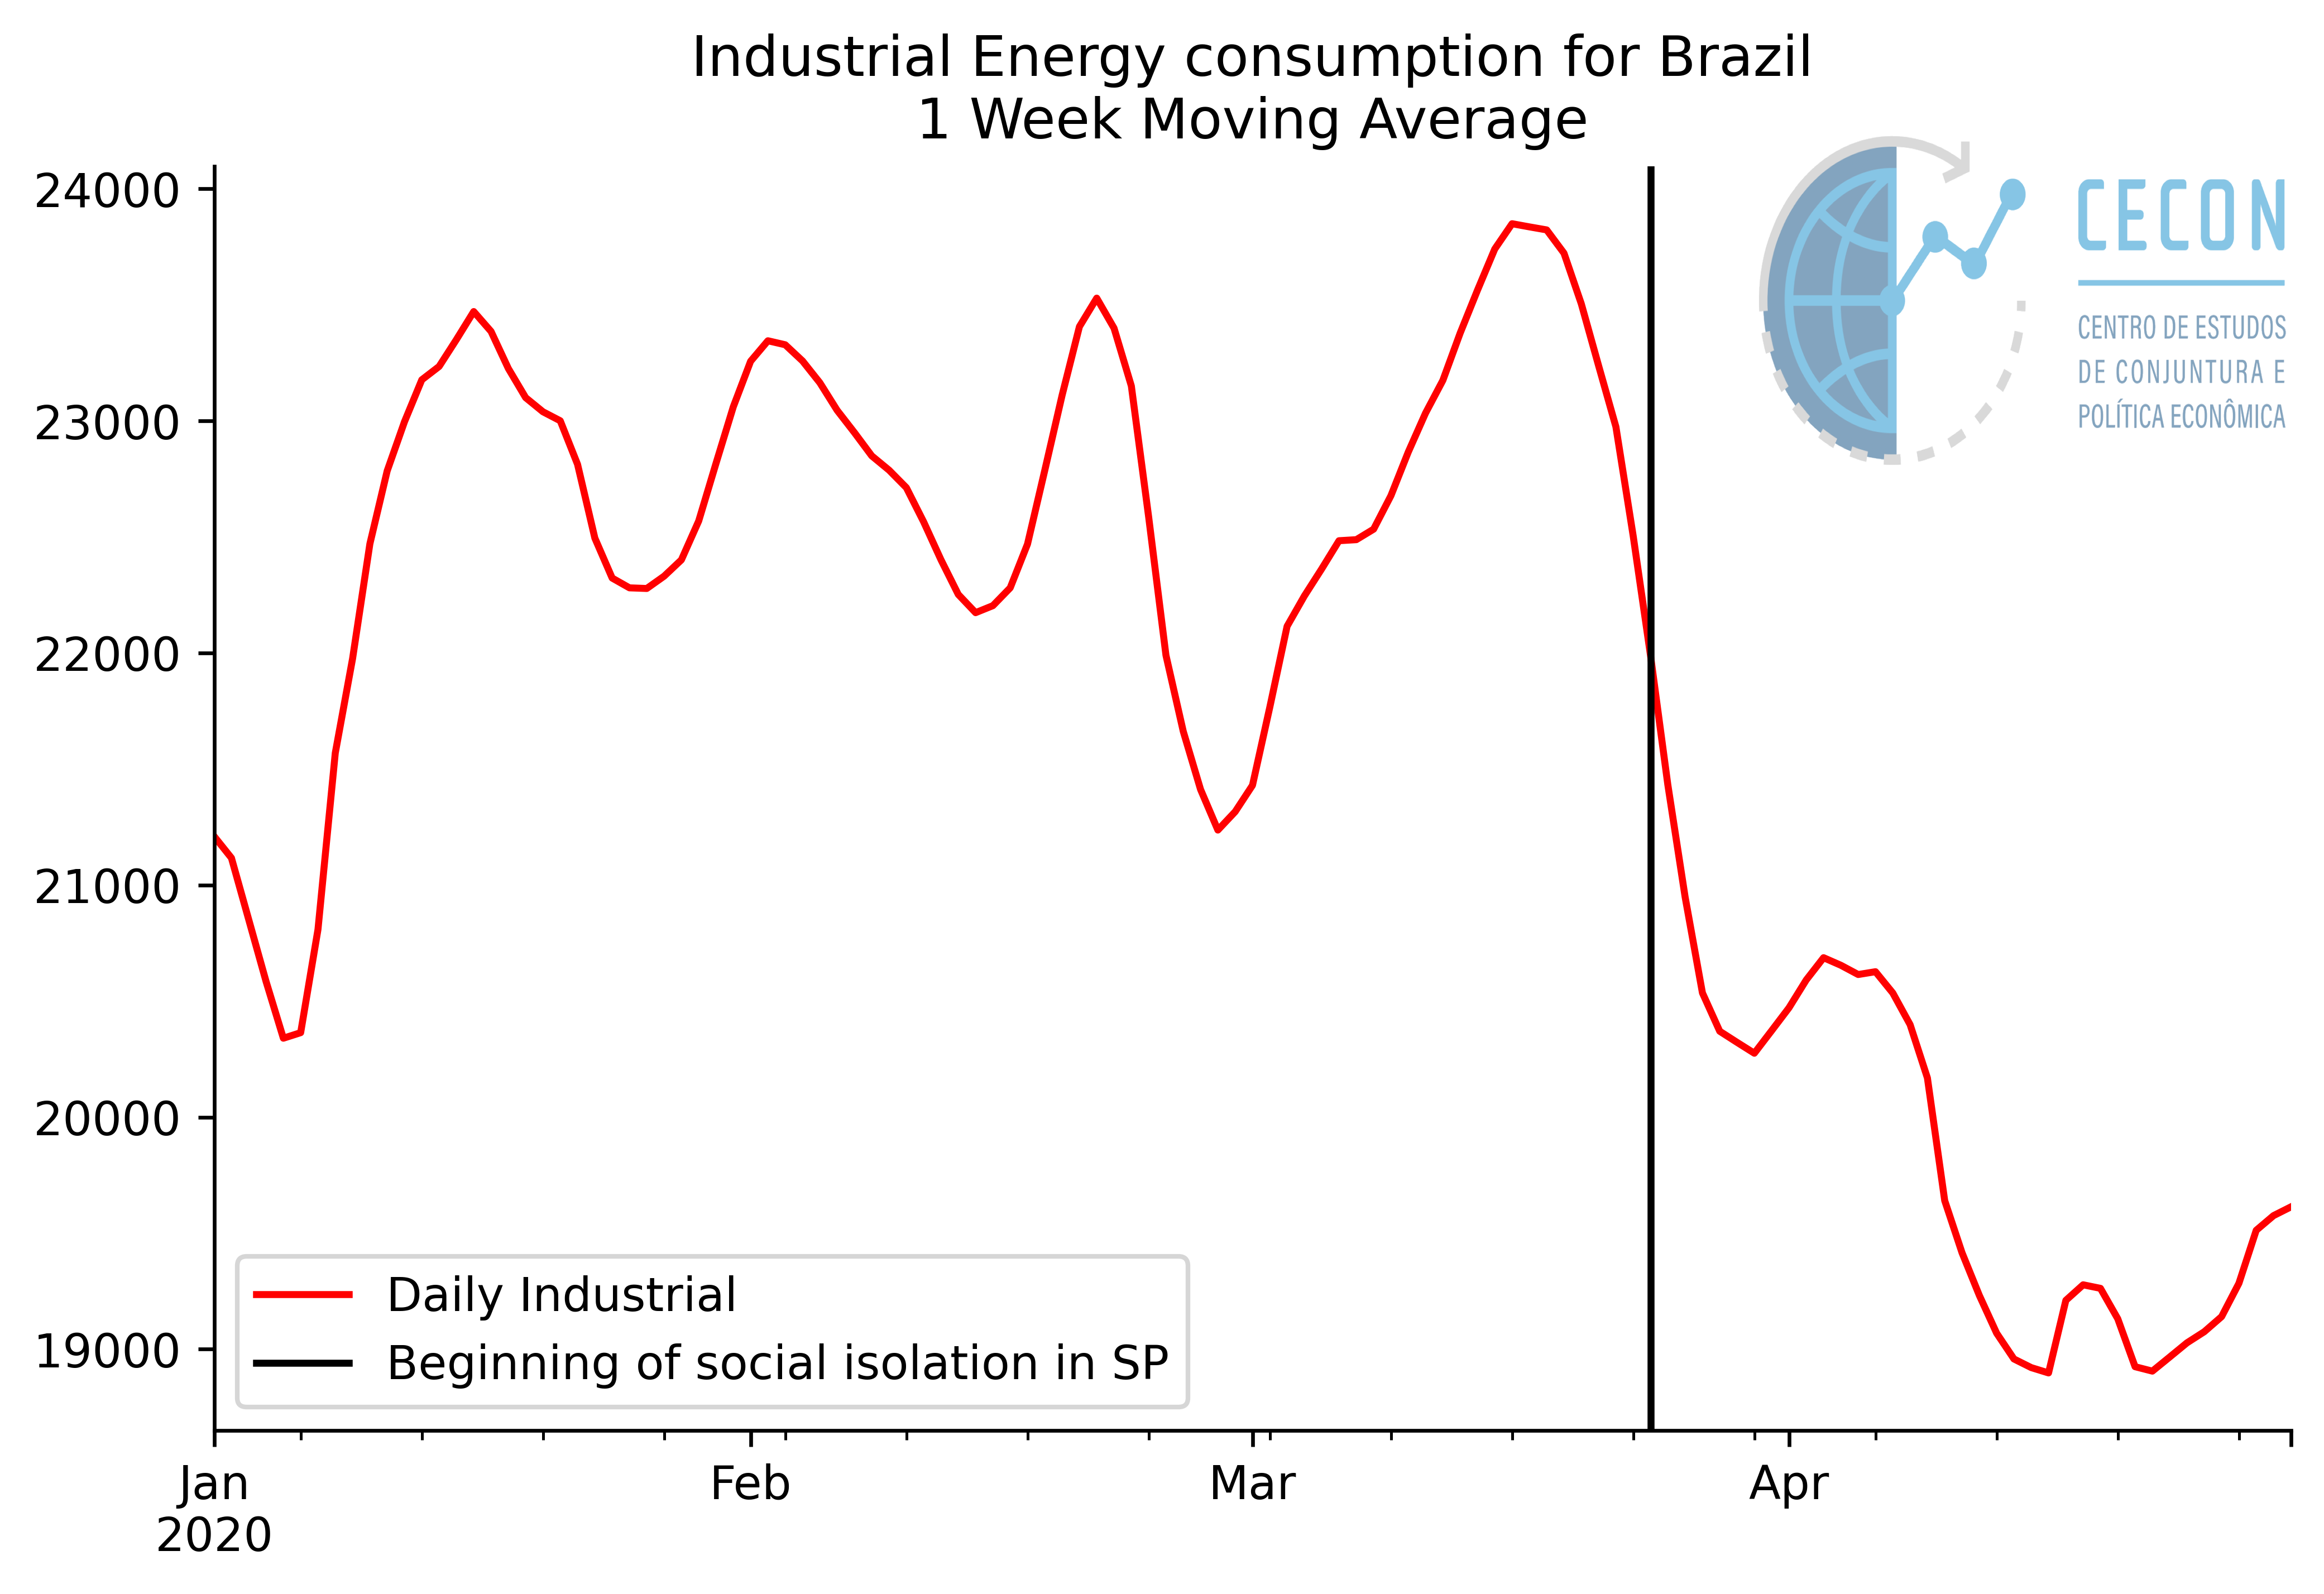

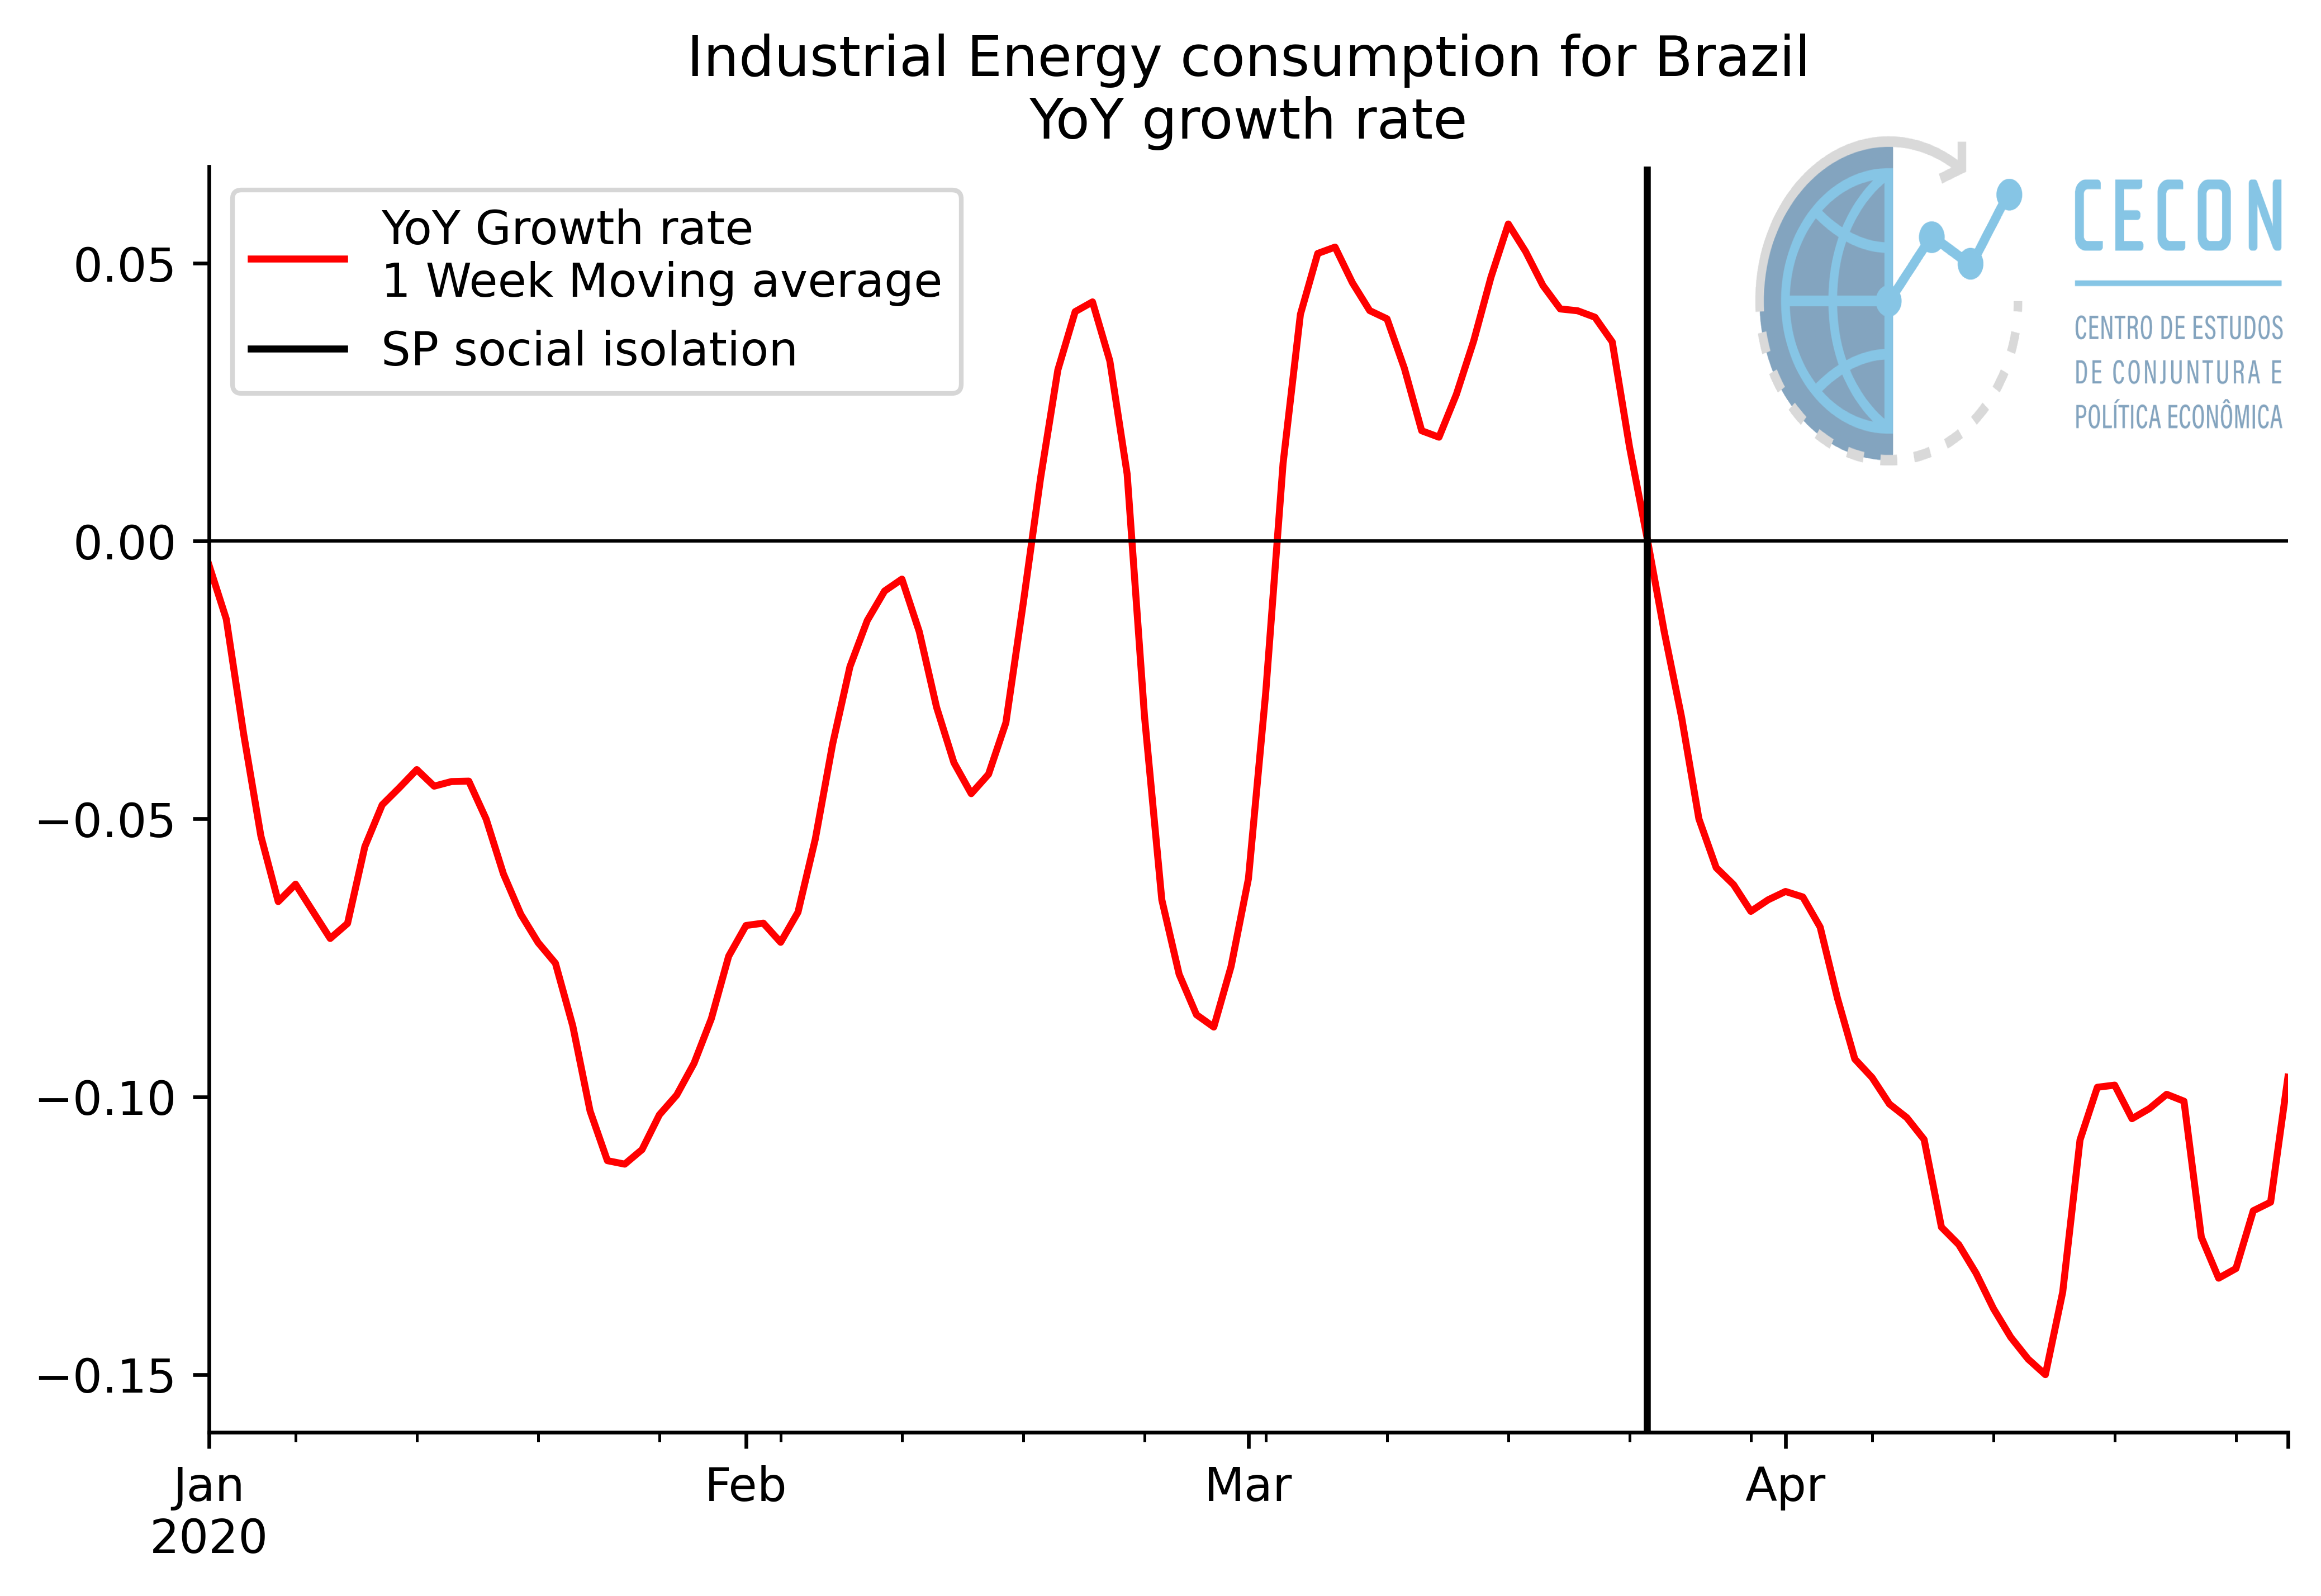

In [129]:
country="Brazil"
units="MWmed"
days=365
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
energy_bra[["Daily Industrial"]].rolling(7).mean()["2020":].plot(ax=ax, 
         ls='-', 
         title= f"Industrial Energy consumption for {country}\n1 Week Moving Average",
         color='red'
        )
#ax.axvline(x = '2020-03-18', color='black', ls='-', lw=1.5, label='More than 60 COVID19 cases')
ax.axvline(x = '2020-03-24', color='black', ls='-', lw=1.5, label='Beginning of social isolation in SP')
ax.legend()
ax2 = plt.axes([0.7,0.7,0.2,0.2])
ax2.imshow(logo, aspect='auto', zorder=0, alpha=.5)
ax2.axis('off')
sns.despine()
plt.show()
fig.savefig(
    f"../figs/Energia/DailyEnergyConsumption_{country}_{units}_level_Industrialshares.svg", 
    dpi = 300, 
    bbox_inches='tight',pad_inches=0
)


fig, ax = plt.subplots(figsize=(8,5), dpi=300)
# energy_bra[["Daily Industrial"]].pct_change(days)["2020":].plot(ax=ax, 
#          ls='-', 
#          title= f"Industrial Energy consumption for {country}",
#          color='red',
#          label="Year over Year Growth rate",
#          zorder=-1
#         )
energy_bra[["Daily Industrial"]].pct_change(days).rolling(7).mean()["2020":].plot(ax=ax, 
         ls='-', 
         label="1 Week Moving average",
         title= f"Industrial Energy consumption for {country}\nYoY growth rate",
         color='red'
        )
#ax.axvline(x = '2020-03-18', color='black', ls='-', lw=1.5, label='More than 60 COVID19 cases')
ax.axvline(x = '2020-03-24', color='black', ls='-', lw=1.5, label='Beginning of social isolation in SP')
ax.legend(labels=("YoY Growth rate\n1 Week Moving average", 'SP social isolation'))
ax.axhline(y=0, ls='-', color='black', lw=.7)

ax2 = plt.axes([0.7,0.7,0.2,0.2])
ax2.imshow(logo, aspect='auto', zorder=0, alpha=.5)
ax2.axis('off')
sns.despine()
plt.show()
fig.savefig(
    f"../figs/Energia/DailyEnergyConsumption_{country}_{units}_growth_Industrialshares.svg", 
    dpi = 300, 
    bbox_inches='tight',pad_inches=0
)


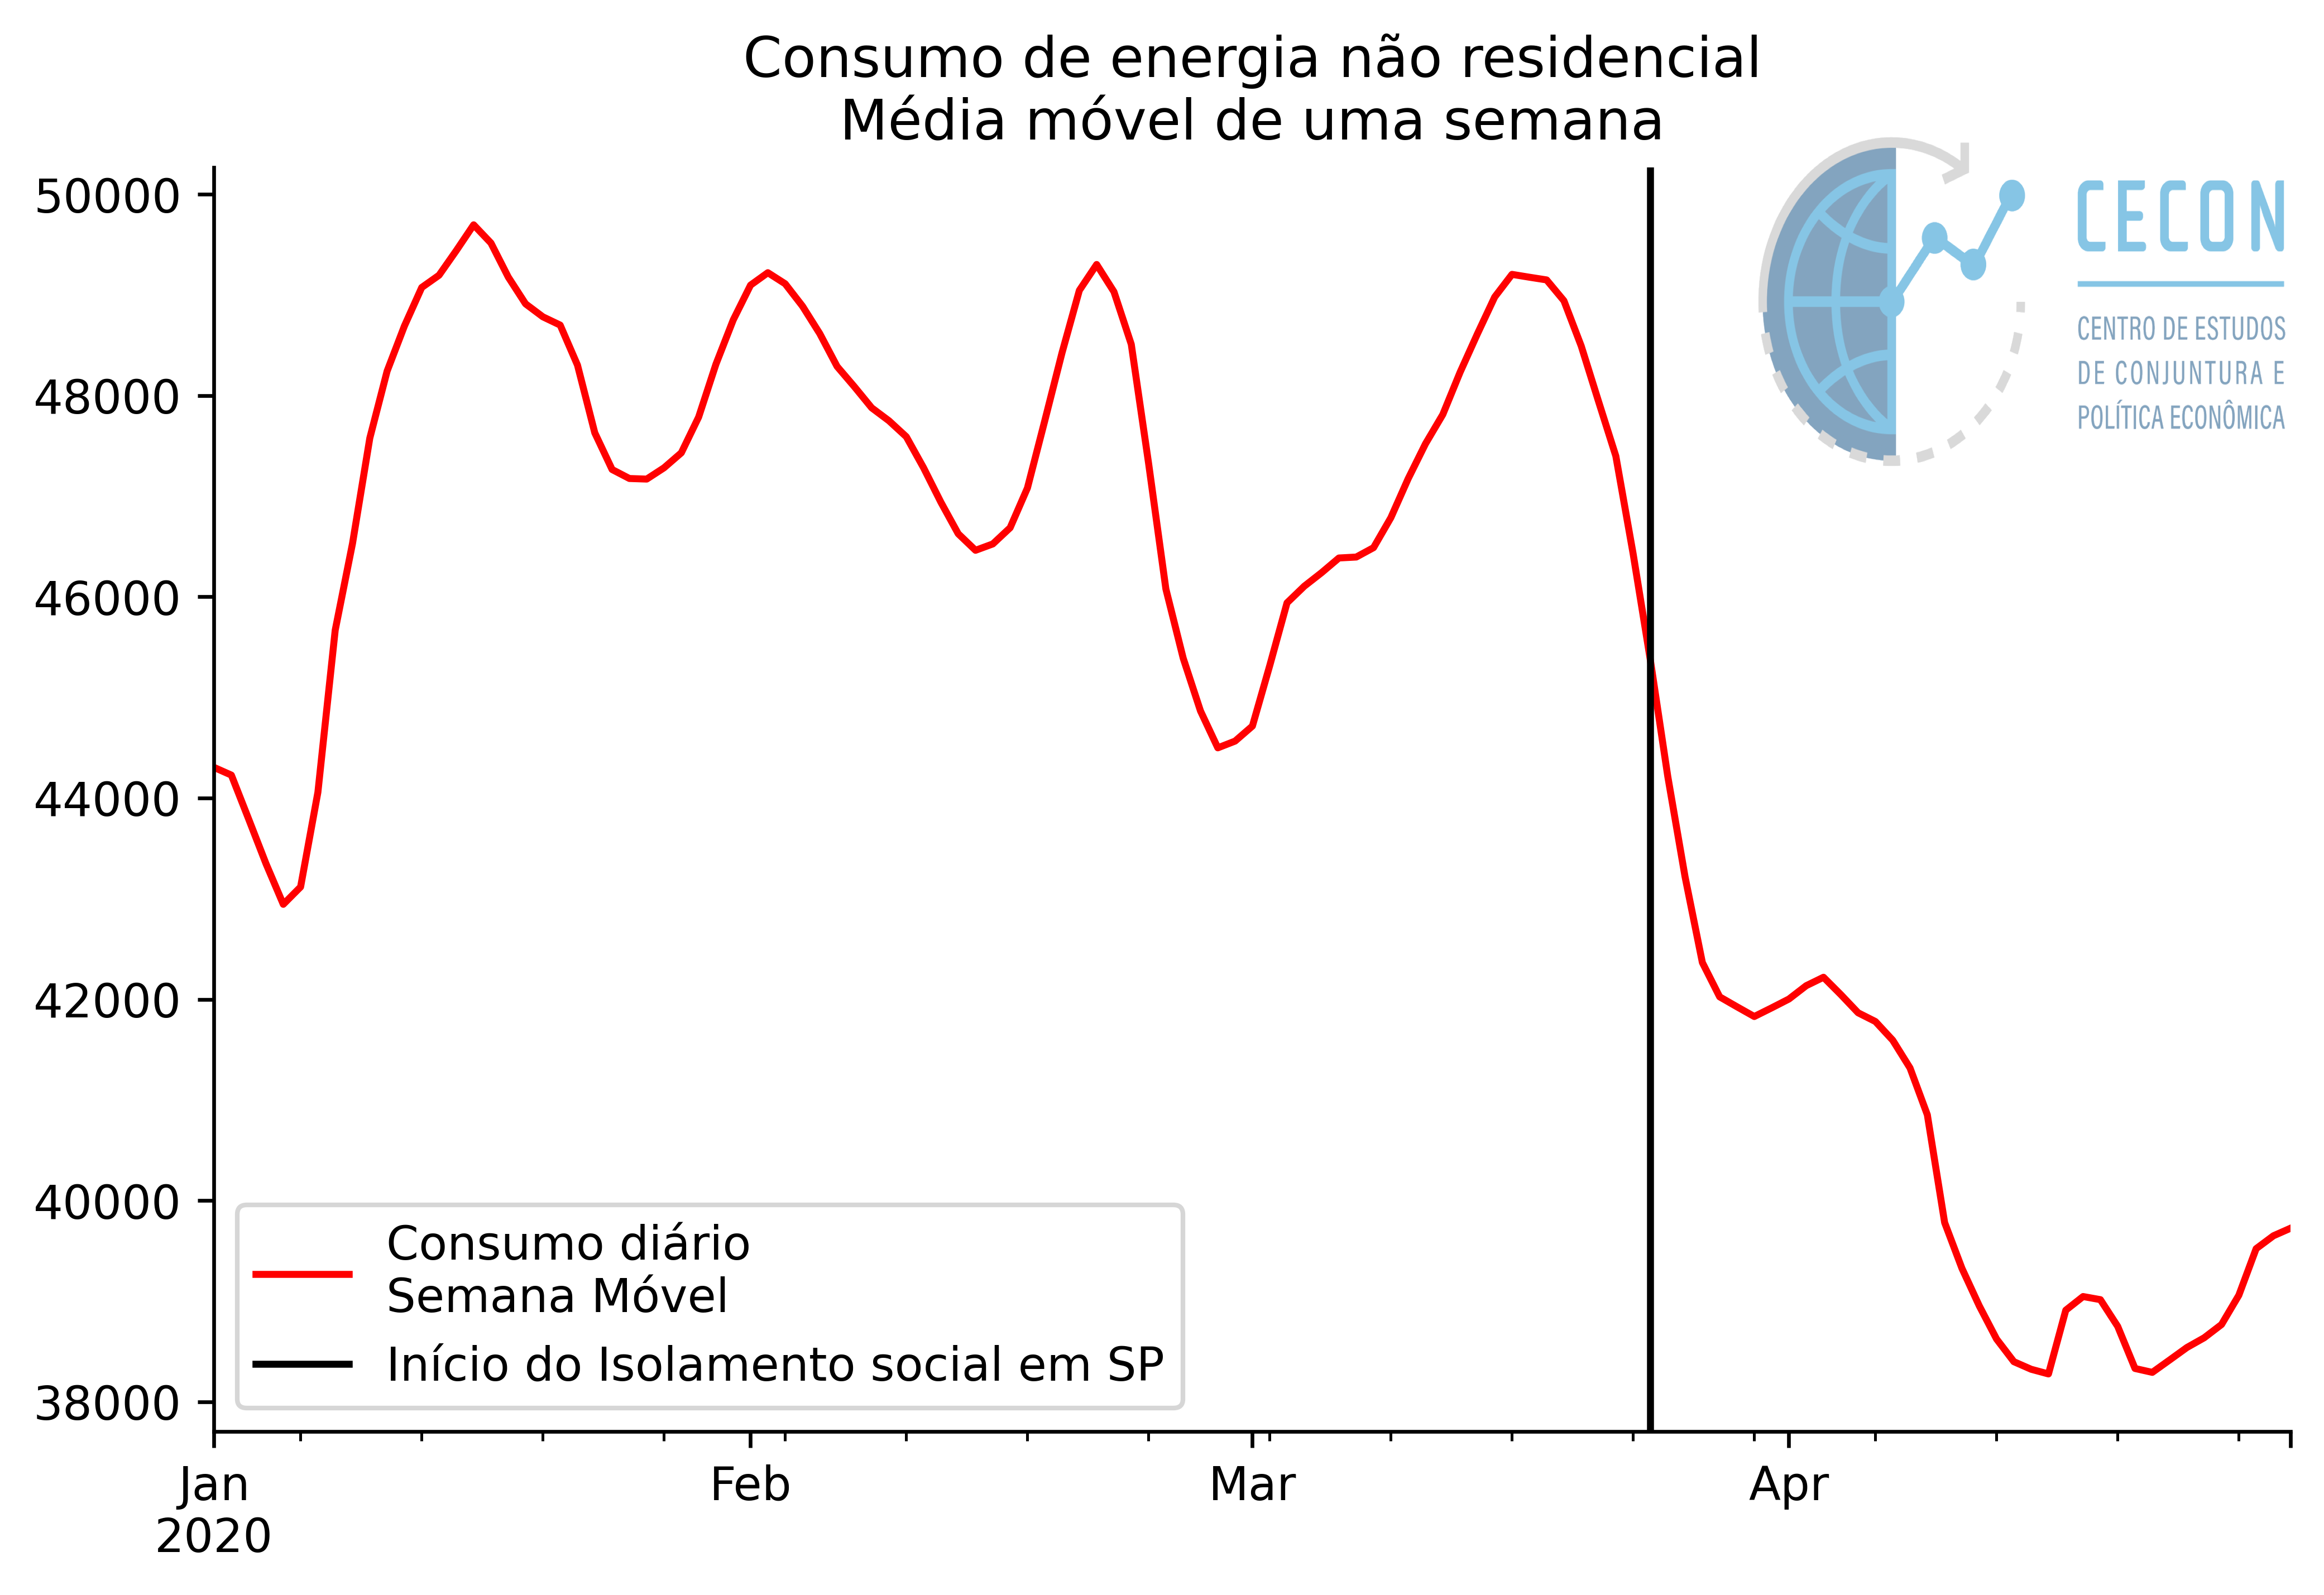

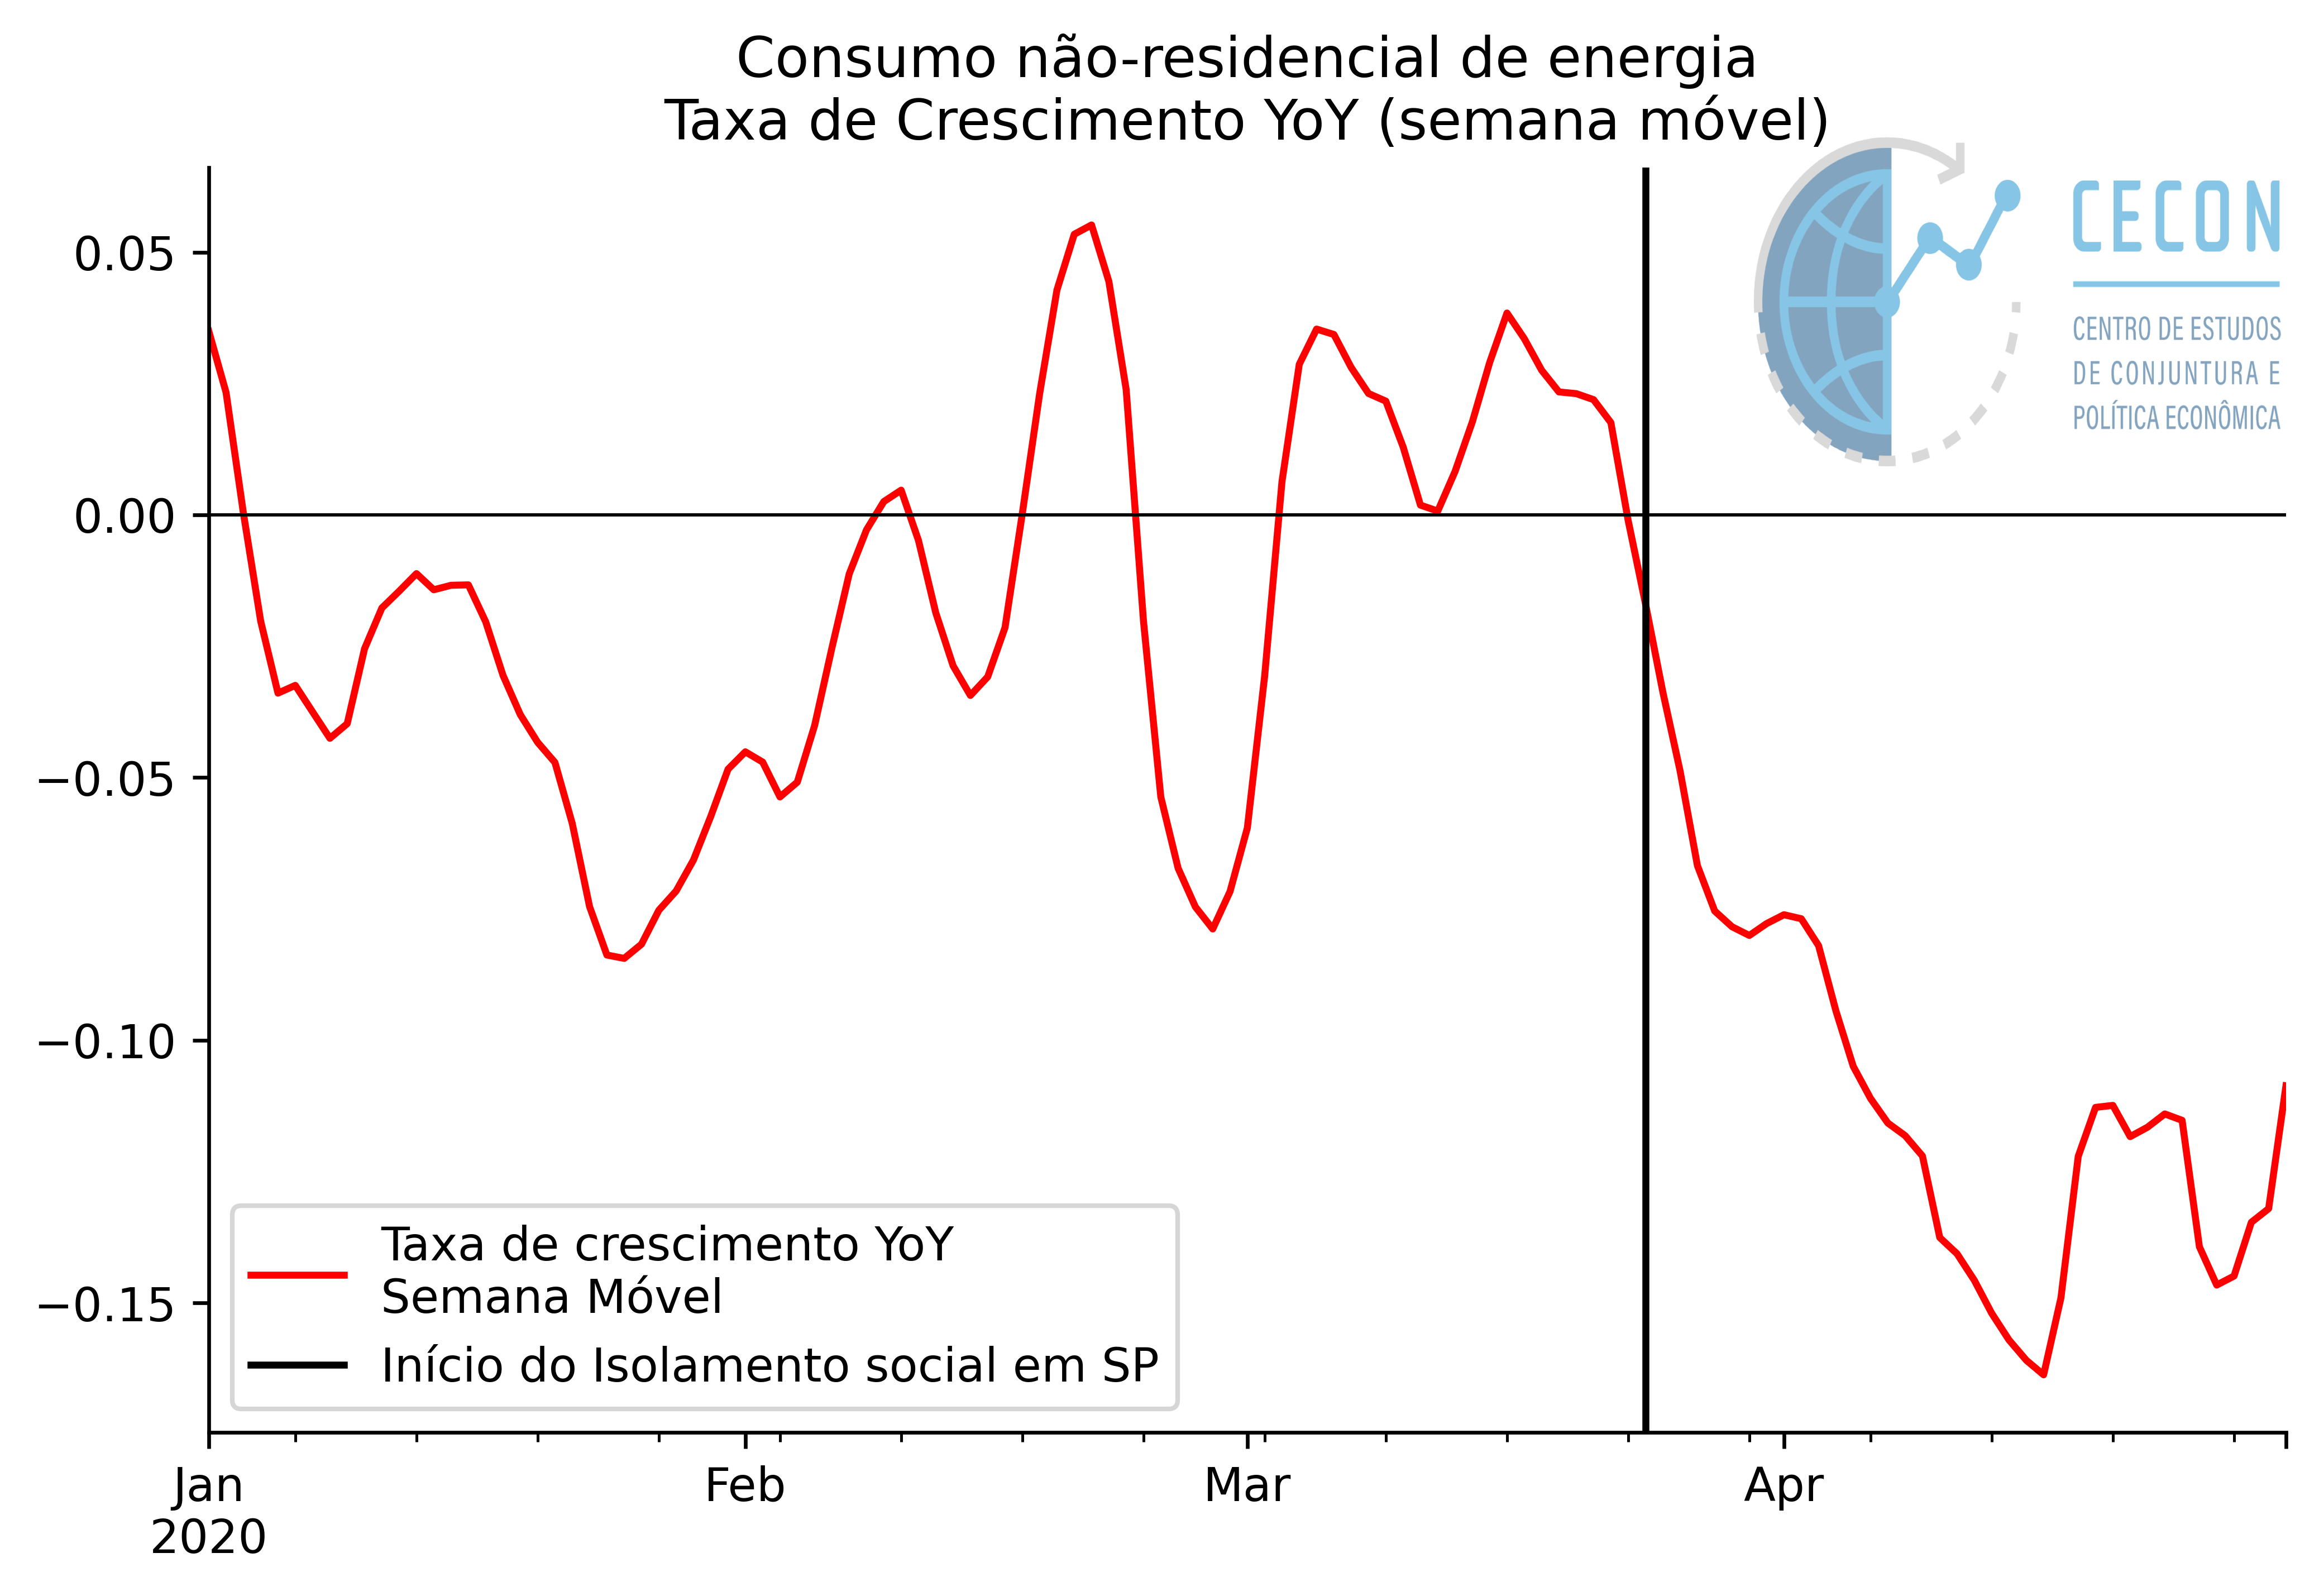

In [134]:
country="Brazil"
units="MWmed"
days=365
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
energy_bra[["Daily Non-Residential"]].rolling(7).mean()["2020":].plot(ax=ax, 
         ls='-', 
         title= f"Consumo de energia não residencial\nMédia móvel de uma semana",
         color='red',
         label='Consumo diário'
        )
#ax.axvline(x = '2020-03-18', color='black', ls='-', lw=1.5, label='More than 60 COVID19 cases')
ax.axvline(x = '2020-03-24', color='black', ls='-', lw=1.5, label='Início do isolamento social em SP')
ax.legend(labels=("Consumo diário\nSemana Móvel", 'Início do Isolamento social em SP'))
ax2 = plt.axes([0.7,0.7,0.2,0.2])
ax2.imshow(logo, aspect='auto', zorder=0, alpha=.5)
ax2.axis('off')
sns.despine()
plt.show()
fig.savefig(
    f"../figs/Energia/DailyEnergyConsumption_{country}_{units}_level_Non-Residentialshares.svg", 
    dpi = 300, 
    bbox_inches='tight',pad_inches=0
)


fig, ax = plt.subplots(figsize=(8,5), dpi=300)
# energy_bra[["Daily Non-Residential"]].pct_change(days)["2020":].plot(ax=ax, 
#          ls='-', 
#          title= f"Non-Residential Energy consumption for {country}",
#          color='red',
#          label="Year over Year Growth rate",
#          zorder=-1
#         )
energy_bra[["Daily Non-Residential"]].pct_change(days).rolling(7).mean()["2020":].plot(ax=ax, 
         ls='-', 
         title= f"Consumo não-residencial de energia\nTaxa de Crescimento YoY (semana móvel)",
         label="1 Week Moving average",
         color='red'
        )
#ax.axvline(x = '2020-03-18', color='black', ls='-', lw=1.5, label='More than 60 COVID19 cases')
ax.axvline(x = '2020-03-24', color='black', ls='-', lw=1.5, label='Beginning of social isolation in SP')
ax.legend(labels=("Taxa de crescimento YoY\nSemana Móvel", 'Início do Isolamento social em SP'))
ax.axhline(y=0, ls='-', color='black', lw=.7)

ax2 = plt.axes([0.7,0.7,0.2,0.2])
ax2.imshow(logo, aspect='auto', zorder=0, alpha=.5)
ax2.axis('off')
sns.despine()
plt.show()
fig.savefig(
    f"../figs/Energia/DailyEnergyConsumption_{country}_{units}_growth_Non-Residentialshares.svg", 
    dpi = 300, 
    bbox_inches='tight',pad_inches=0
)


## France: FRA

<ipython-input-4-4fa9ab8fbc1c>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


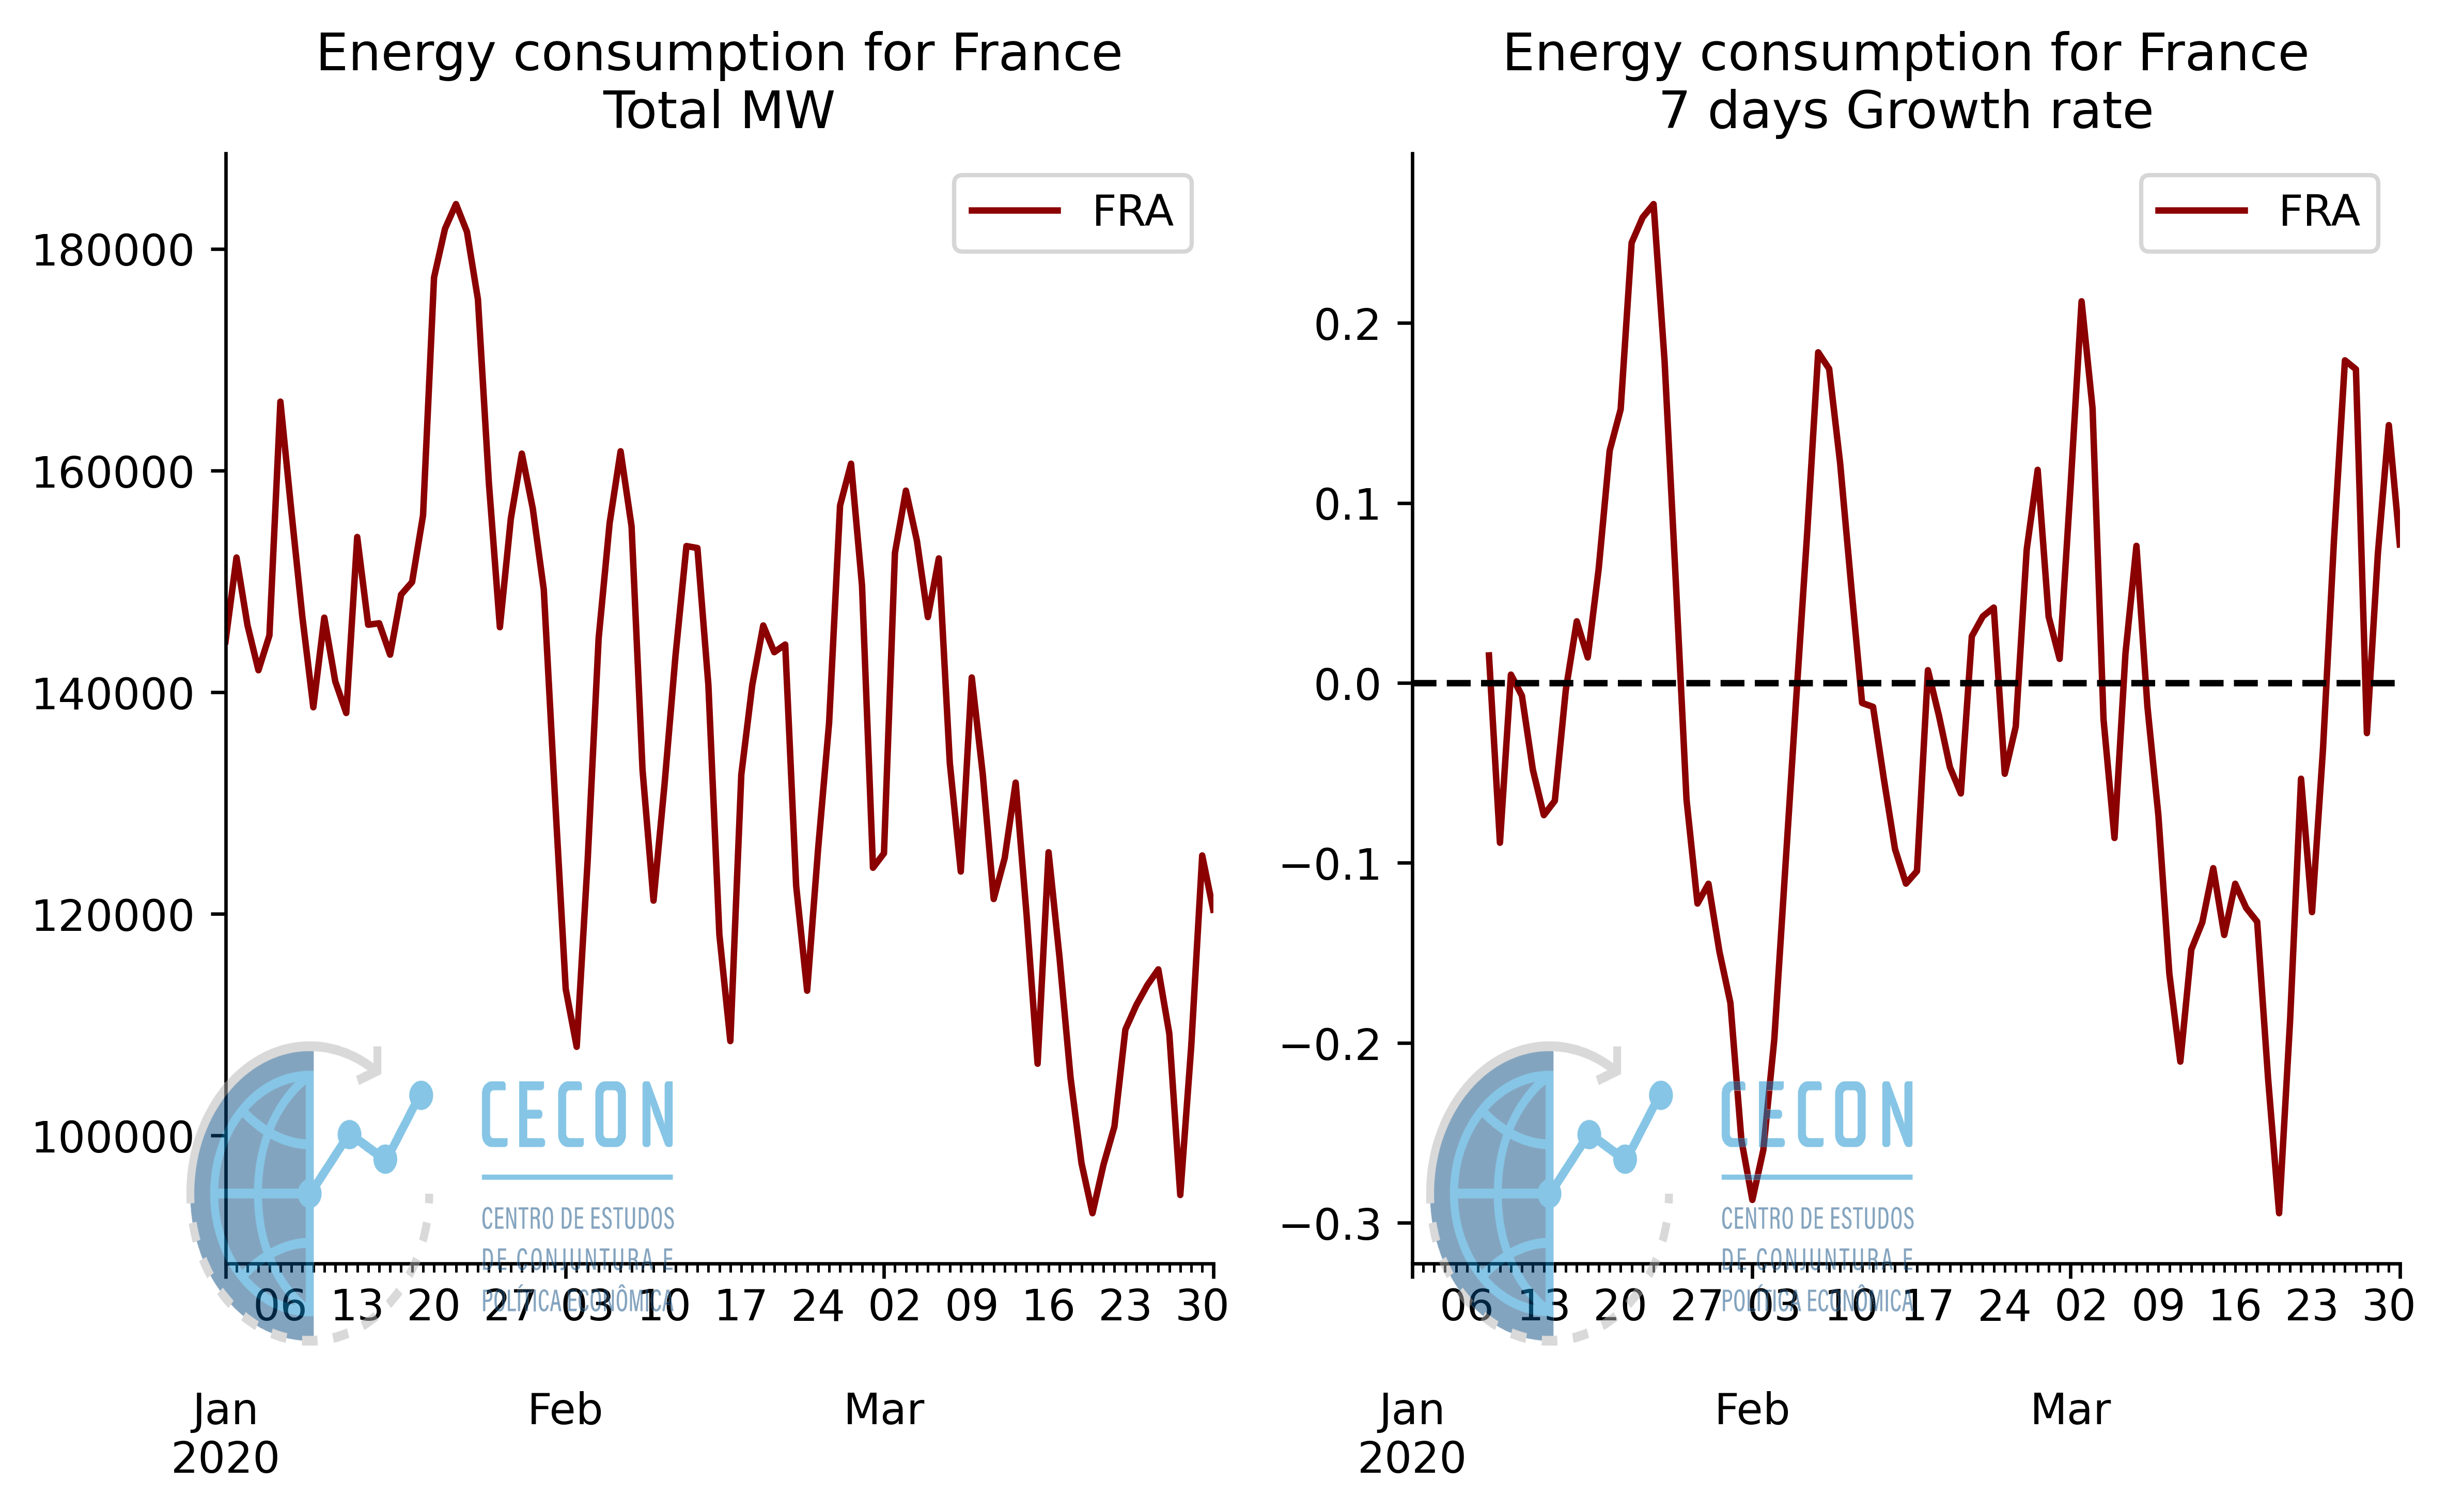

FRA
                         
2020-01-01  144591.666667
2020-01-02  152146.041667
2020-01-03  146048.125000
2020-01-04  141978.208333
2020-01-05  145123.791667
...                   ...
2020-03-27  109205.500000
2020-03-28   94641.291667
2020-03-29  108061.956522
2020-03-30  125270.750000
2020-03-31  120378.583333

[91 rows x 1 columns]

In [9]:
url = 'https://www.data.gouv.fr/en/datasets/r/cfc27ff9-1871-4ee8-be64-b9a290c06935'
fra = pd.read_csv(
    url,
    sep = ';',
    #'../data/Energy/FRA.csv',
    usecols=['Date - Heure', 'Date', 'Heure', 'Consommation brute totale (MW)'],
    index_col=['Date'], 
    parse_dates=True, dayfirst=True, # Check
    #thousands=',' # Check
)
fra = fra.sort_values(by='Date - Heure').drop('Date - Heure', axis='columns')
fra.reset_index(inplace=True)
fra = (fra.groupby(by='Date').mean())
fra = fra[['Consommation brute totale (MW)']]
fra = fra["2020":]#/1000 # Check later
fra = fra.dropna()
fra.columns = ["FRA"]
fra.index.name=''
fra.to_csv('../data/Energy/FRA.csv')

ploter(
    df=fra, 
    country="France", 
    days = 7,
    units="MW"
)

infos['Country'].append("FRA")
infos["Type"].append('Consumption')
infos['Usage'].append(np.nan)
infos['Source'].append('All')
infos['Units'].append("MW")
infos['Frequency'].append('halfhour')
infos['Link'].append(url)

fra

## Spain: SPA

<ipython-input-4-4fa9ab8fbc1c>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


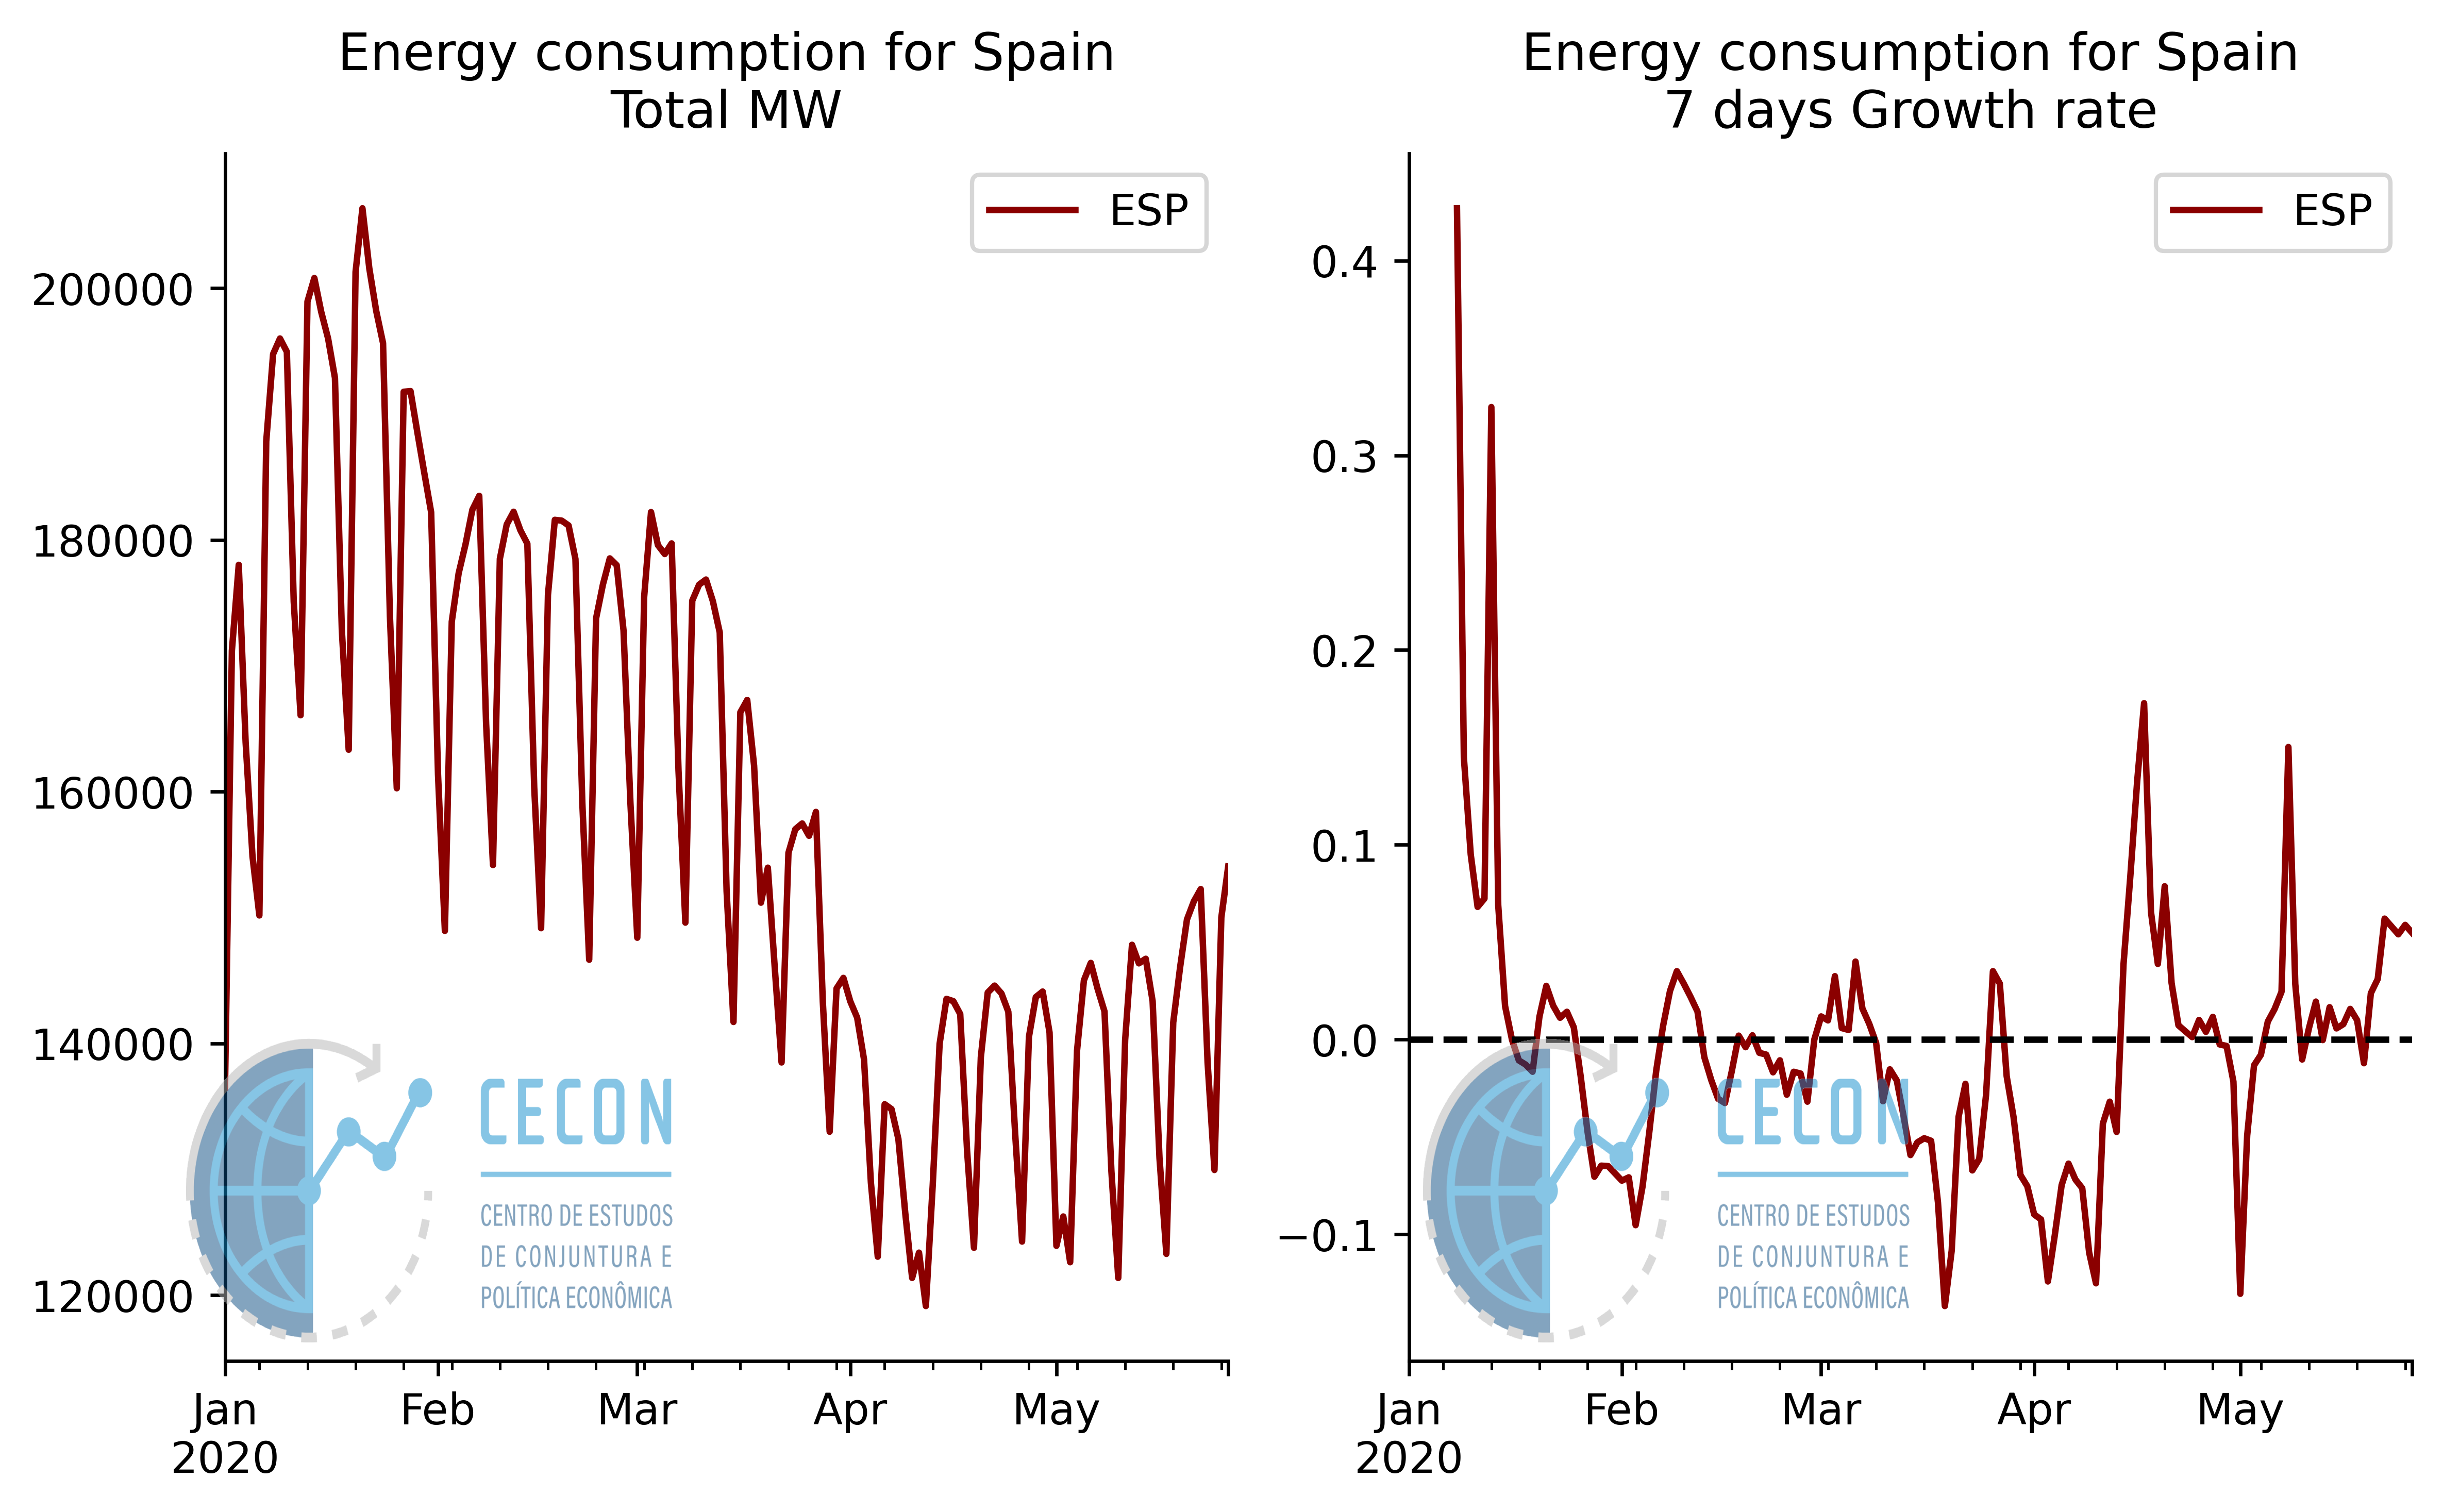

ESP
                         
2020-01-01  136497.143836
2020-01-02  171186.726027
2020-01-03  178015.410959
2020-01-04  163925.520548
2020-01-05  154851.109589
...                   ...
2020-05-22  152254.828767
2020-05-23  138493.890411
2020-05-24  129936.602740
2020-05-25  149997.123288
2020-05-26  154048.458904

[147 rows x 1 columns]

In [10]:
datelist = pd.date_range(
    start = "01/01/2020",
    end = str((dt.today()- timedelta(days=2)).strftime("%d/%m/%Y")),
    freq='D', 
).to_pydatetime().tolist()

spa = pd.DataFrame()
for day in datelist:
    #url = f'https://demanda.ree.es/visiona/peninsula/demanda/tablas/{day:%Y-%m-%d}/1'
    url = f"https://apidatos.ree.es/es/datos/demanda/demanda-tiempo-real?start_date={day:%Y-%m-%d}T00:00&end_date={(day + timedelta(days=1)):%Y-%m-%d}T01:00&time_trunc=hour"
    response=requests.request(url=url, method='get')
    data=response.json()
    value = pd.DataFrame(
    data['included'][0]['attributes']['values'],
        )
    value = value[['value']].rolling(6).sum()
    value = value[['value']].mean() # Unity: MW
    value = pd.DataFrame({
    'ESP': value,
    'Date': [day.strftime("%Y-%m-%d")]
    },)
    value['Date'] = pd.to_datetime(value['Date'])
    value = value.set_index('Date')
    value.index.name=''
    spa = spa.append(value)
spa.to_csv('../data/Energy/ESP.csv')

ploter(
    df=spa, 
    country="Spain", 
    days = 7,
    units="MW"
)

infos['Country'].append("ESP")
infos["Type"].append('Consumption')
infos['Usage'].append(np.nan)
infos['Source'].append('All')
infos['Units'].append("MW")
infos['Frequency'].append('10 minutes')
infos['Link'].append(url)

spa

# Aux

In [11]:
infos = pd.DataFrame(infos)
infos = infos.set_index('Country')
infos

Type  Usage Source       Units    Frequency  \
Country                                                       
AUS      Consumption    NaN    All  Total[MWh]  Quarterhour   
GER      Consumption    NaN    All  Total[MWh]  Quarterhour   
LUX      Consumption    NaN    NaN         MWh  Quarterhour   
BRA           Demand    NaN    All       MWmed       Dailly   
FRA      Consumption    NaN    All          MW     halfhour   
ESP      Consumption    NaN    All          MW   10 minutes   

                                                      Link  
Country                                                     
AUS                                                    NaN  
GER                                                    NaN  
LUX                                                    NaN  
BRA      http://sdro.ons.org.br/SDRO/DIARIO/2020_04_30/...  
FRA      https://www.data.gouv.fr/en/datasets/r/cfc27ff...  
ESP      https://apidatos.ree.es/es/datos/demanda/deman...

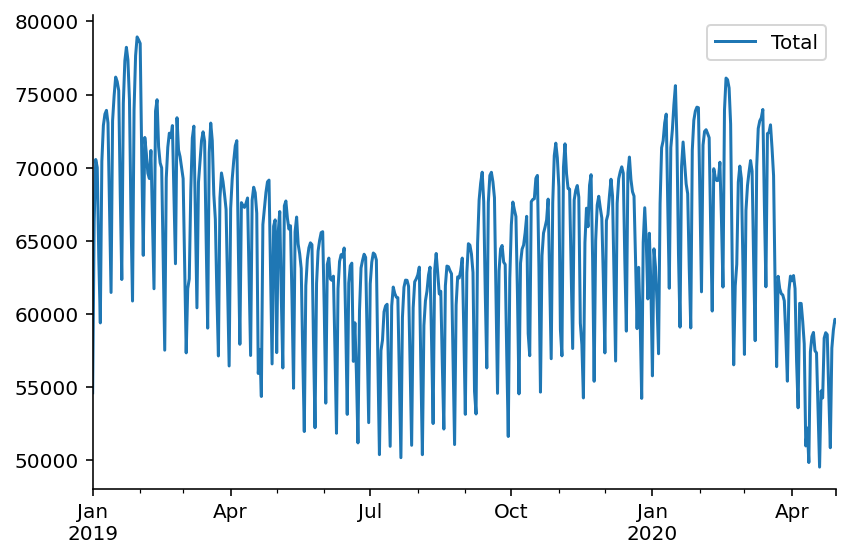

In [12]:
datelist = pd.date_range(
    start = "31/01/2019",
    end = "26/05/2020",
    freq='M',
).to_pydatetime().tolist()
datelist = [date.strftime("%Y_%m_%d") for date in datelist] #+ [str(dt.today().strftime("%Y_%m_%d"))]

aux = pd.DataFrame()

for date in datelist:
    url = f"http://sdro.ons.org.br/SDRO/DIARIO/{date}/HTML/07_DadosDiariosAcumulados_Regiao.html"
    aux = aux.append(pd.read_html(
        url,
        index_col = [0], skiprows=1, header=0, 
        thousands='.', #decimal=','
            )[0])
#aux = aux[["Total"]] # TODO Check later: MWmed dia -> MW

aux.index = pd.date_range(
    start = aux.index[0],
    end = aux.index[-1],
    freq='D', 
)

aux.to_csv('../data/Energy/BRA_aux.csv')


aux[["Total"]].plot()
plt.tight_layout()
sns.despine()
plt.show()